Changed ignore iters, lr ranges, computation of best metric and using **average of last 10 runs** metric to store new model

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
import random
from models_ms import ModelAPIF, ModelBPIF
from hyperparameter_options import params_pif as hyperparams

In [6]:
torch.__version__

'1.0.0'

In [7]:
gpu = 1
multi_gpus = [1, 2]
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
train_h5 = h5py.File('/ritter/share/data/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/ritter/share/data/MS/CIS/holdout_dataset.h5', 'r')

In [10]:
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_train, y_train = train_h5['X'], train_h5['y']

In [11]:
X = np.concatenate([X_train, X_holdout])
y = np.concatenate([y_train, y_holdout])

In [12]:
# define dataset

In [13]:
class MSDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

# Define the classifier

In [14]:
"""if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)"""

'if multi_gpus is None:\n    net = SixtyFourNet().cuda(gpu)\nelse:\n    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)'

In [15]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [16]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=None,
    num_epochs=35,
    retain_metric=None
):      

    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    random_states = np.arange(20, 30) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load new random data split each outer fold
        # separate new test set
        X_train, _, y_train, _ = train_test_split(data[0], data[1], test_size=0.15, random_state=r)
        if zero_one_normalize:
            intensity = IntensityRescale()
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        all_indices = list(range(len(X_train)))
        train_idx, val_idx = train_test_split(all_indices, test_size=0.1, random_state=12)
        print(len(train_idx))
        print(len(val_idx))
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        print("Shuffled the data..")
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
            
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelAPIF"
            elif inner_fold < 4:
                model_name = "ModelBPIF"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])
            
            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)

            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            print("Trainable model parameters: {}".format(count_parameters(net)))

            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1

            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            # create dataloaders for specific inner folds (due to batch size)
            train_loader = DataLoader(
                ms_data_train, batch_size=b, num_workers=4, sampler=train_sampler
            )
            val_loader = DataLoader(
                ms_data_train, batch_size=1, num_workers=1, sampler=val_sampler
            )

            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=5,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)        
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [17]:
num_epochs = 200
min_iters = 30
ignore_epochs = 40
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [18]:
r = 1

In [19]:
augmentations = [] # augmentations seem to decrease validation accuracy

output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/MS/full_set/10xrandom_splits/experiment_r3/"


###### Starting outer fold 0
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.68604
[0,    10] loss: 0.72364
[0,    15] loss: 0.69382
Time elapsed: 0h:0m:6s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690988
[1,     5] loss: 0.68439
[1,    10] loss: 0.69688
[1,    15] loss: 0.70447
Time elapsed: 0h:0m:8s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691664
[2,     5] loss: 0.68717
[2,    10] loss: 0.70046
[2,    15] loss: 0.69272
Time elapsed: 0h:0m:11s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.46 %
val accuracy_score: 38.46 %
val balanced_accuracy: 35.71 %
Val loss: 0.695187
[3,     5] loss: 0.69455
[3,    10] loss: 0.68743
[3,    15] loss: 0.69275
Time elapsed: 0h:

[33,    10] loss: 0.36417
[33,    15] loss: 0.68248
Time elapsed: 0h:1m:33s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.39 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.411182
[34,     5] loss: 0.43555
[34,    10] loss: 0.55049
[34,    15] loss: 0.41438
Time elapsed: 0h:1m:35s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.81 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.480088
[35,     5] loss: 0.48875
[35,    10] loss: 0.60309
[35,    15] loss: 0.49402
Time elapsed: 0h:1m:38s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.32 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.474629
[36,     5] loss: 0.54541
[36,    10] loss: 0.45415
[36,    15] loss: 0.56222
Time elapsed: 0h:1m:41s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.53 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.409666
[37,     5] loss: 0.36744
[37,    10] loss: 0.49830
[3

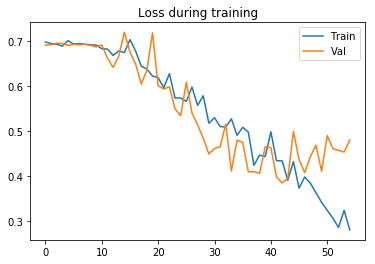

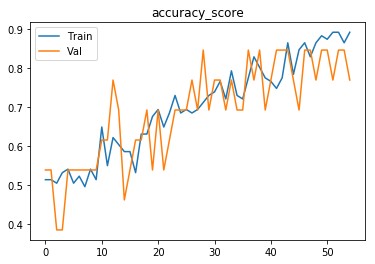

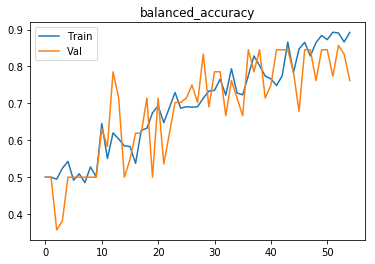

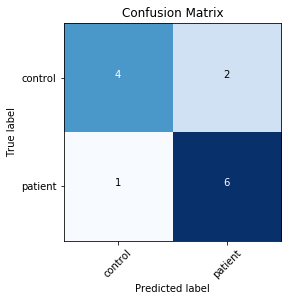

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69946
[0,    10] loss: 0.69767
[0,    15] loss: 0.70478
[0,    20] loss: 0.69416
[0,    25] loss: 0.70331
Time elapsed: 0h:0m:2s
train accuracy_score: 41.44 %
train balanced_accuracy: 41.18 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694847
[1,     5] loss: 0.69190
[1,    10] loss: 0.69385
[1,    15] loss: 0.70421
[1,    20] loss: 0.69329
[1,    25] loss: 0.69277
Time elapsed: 0h:0m:5s
train accuracy_score: 50.45 %
train balanced_accuracy: 51.71 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696818
[2,     5] loss: 0.68891
[2,    10] loss: 0.69082
[2,    15] loss: 0.69031
[2,    20] loss: 0.69574
[2,    25] loss: 0.68922
Time elapsed: 0h:0m:8s
train accuracy_score: 50.45 %
train balanced_accuracy: 51.17 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692027


val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.615935
[28,     5] loss: 0.61148
[28,    10] loss: 0.61092
[28,    15] loss: 0.61653
[28,    20] loss: 0.64175
[28,    25] loss: 0.70620
Time elapsed: 0h:1m:30s
train accuracy_score: 65.77 %
train balanced_accuracy: 66.18 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.616581
[29,     5] loss: 0.57079
[29,    10] loss: 0.69848
[29,    15] loss: 0.66239
[29,    20] loss: 0.74176
[29,    25] loss: 0.55262
Time elapsed: 0h:1m:33s
train accuracy_score: 62.16 %
train balanced_accuracy: 61.99 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.642122
[30,     5] loss: 0.64950
[30,    10] loss: 0.54527
[30,    15] loss: 0.67330
[30,    20] loss: 0.70188
[30,    25] loss: 0.65413
Time elapsed: 0h:1m:36s
train accuracy_score: 60.36 %
train balanced_accuracy: 59.99 %
val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.673066
[31,     5] loss: 0.70529
[31,    10]

val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.463651
[56,     5] loss: 0.37104
[56,    10] loss: 0.27312
[56,    15] loss: 0.53435
[56,    20] loss: 0.27578
[56,    25] loss: 0.21047
Time elapsed: 0h:2m:58s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.40 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.479894
[57,     5] loss: 0.33714
[57,    10] loss: 0.30569
[57,    15] loss: 0.17491
[57,    20] loss: 0.22245
[57,    25] loss: 0.29610
Time elapsed: 0h:3m:1s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.35 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.481606
[58,     5] loss: 0.27140
[58,    10] loss: 0.26492
[58,    15] loss: 0.15377
[58,    20] loss: 0.30201
[58,    25] loss: 0.23346
Time elapsed: 0h:3m:4s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.48 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.546951
[59,     5] loss: 0.24840
[59,    10] l

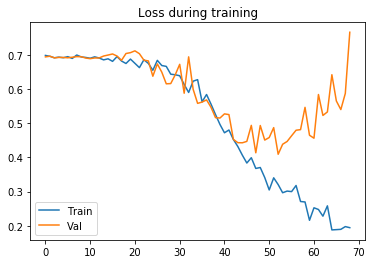

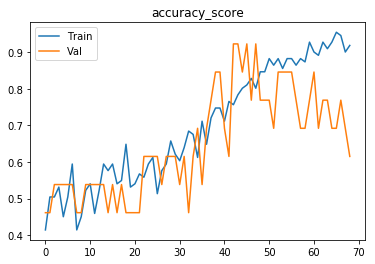

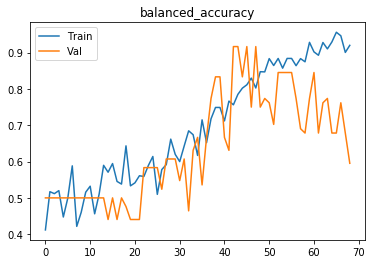

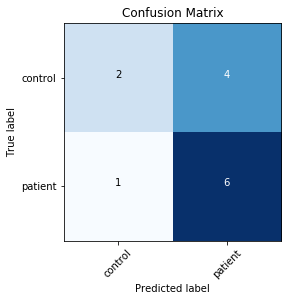

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.70783
[0,    10] loss: 0.69613
[0,    15] loss: 0.68975
Time elapsed: 0h:0m:2s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691883
[1,     5] loss: 0.70015
[1,    10] loss: 0.69229
[1,    15] loss: 0.69018
Time elapsed: 0h:0m:6s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.27 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692633
[2,     5] loss: 0.68854
[2,    10] loss: 0.69441
[2,    15] loss: 0.69742
Time elapsed: 0h:0m:9s
train accuracy_score: 48.65 %
train balanced_accuracy: 47.51 %
val accuracy_score: 30.77 %
val balanced_accuracy: 29.76 %
Val loss: 0.694717
[3,     5] loss: 0.68969
[3,    10] loss: 0.69762
[3,    15] loss: 0.69228
Time elapsed: 0h:0m:13s
train accuracy_score: 50.45 %
train balanced_accur

Time elapsed: 0h:1m:53s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.68 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.499863
[34,     5] loss: 0.56691
[34,    10] loss: 0.43053
[34,    15] loss: 0.49559
Time elapsed: 0h:1m:57s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.83 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.474307
[35,     5] loss: 0.51051
[35,    10] loss: 0.34227
[35,    15] loss: 0.53053
Time elapsed: 0h:2m:0s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.58 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.490677
[36,     5] loss: 0.51048
[36,    10] loss: 0.40036
[36,    15] loss: 0.43351
Time elapsed: 0h:2m:4s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.36 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.477455
[37,     5] loss: 0.45029
[37,    10] loss: 0.49802
[37,    15] loss: 0.41274
Time elapsed: 0h:2m:7s
train a

Best result during training: 0.85. Saving model..
Finished inner fold.


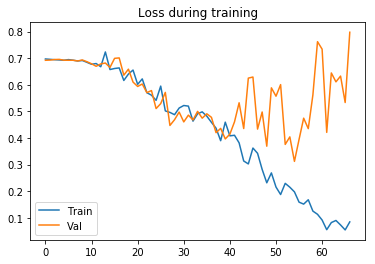

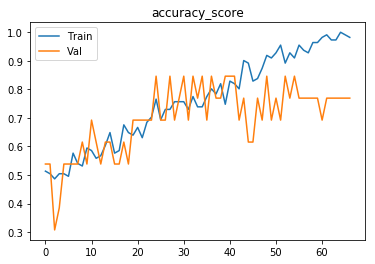

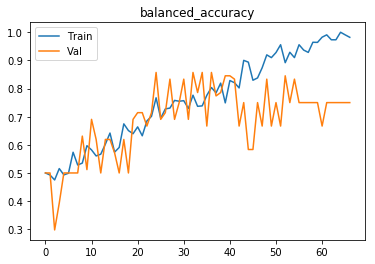

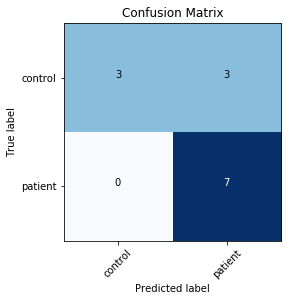

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69553
Time elapsed: 0h:0m:2s
train accuracy_score: 48.65 %
train balanced_accuracy: 47.47 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690835
[1,     5] loss: 0.69251
Time elapsed: 0h:0m:5s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691315
[2,     5] loss: 0.68831
Time elapsed: 0h:0m:8s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.12 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691066
[3,     5] loss: 0.68951
Time elapsed: 0h:0m:11s
train accuracy_score: 52.25 %
train balanced_accuracy: 52.58 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698318
[4,     5] loss: 0.69203
Time elapsed: 0h:0m:14s
train accuracy_score: 54.05 %
train balanced_accuracy: 53.9

val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.582795
[43,     5] loss: 0.58730
Time elapsed: 0h:2m:9s
train accuracy_score: 64.86 %
train balanced_accuracy: 65.20 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.584708
[44,     5] loss: 0.59047
Time elapsed: 0h:2m:12s
train accuracy_score: 70.27 %
train balanced_accuracy: 69.83 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.577817
[45,     5] loss: 0.56131
Time elapsed: 0h:2m:15s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.44 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.599491
[46,     5] loss: 0.59786
Time elapsed: 0h:2m:18s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.59 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.558300
[47,     5] loss: 0.61464
Time elapsed: 0h:2m:21s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.10 %
val accuracy_score: 76.92 %
val balanced_accur

val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.432729
[86,     5] loss: 0.29215
Time elapsed: 0h:4m:15s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.12 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.501515
[87,     5] loss: 0.22039
Time elapsed: 0h:4m:18s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.81 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.366597
[88,     5] loss: 0.22248
Time elapsed: 0h:4m:21s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.06 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.399141
[89,     5] loss: 0.26753
Time elapsed: 0h:4m:24s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.48 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.459958
[90,     5] loss: 0.24162
Time elapsed: 0h:4m:27s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.35 %
val accuracy_score: 76.92 %
val balanced_accu

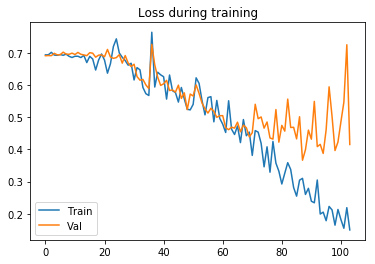

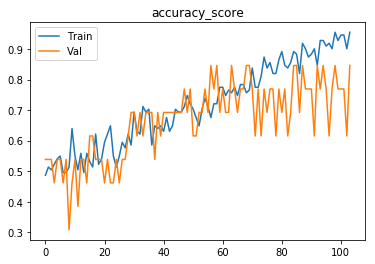

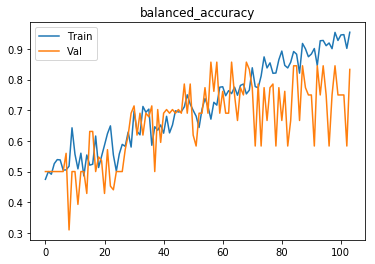

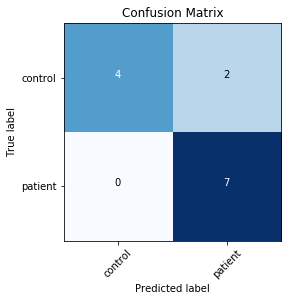

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.67893
[0,    10] loss: 0.70405
[0,    15] loss: 0.69535
[0,    20] loss: 0.69642
[0,    25] loss: 0.69163
Time elapsed: 0h:0m:3s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.51 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.707618
[1,     5] loss: 0.69928
[1,    10] loss: 0.70131
[1,    15] loss: 0.66823
[1,    20] loss: 0.70169
[1,    25] loss: 0.69084
Time elapsed: 0h:0m:7s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.03 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.695730
[2,     5] loss: 0.71689
[2,    10] loss: 0.69466
[2,    15] loss: 0.68410
[2,    20] loss: 0.69818
[2,    25] loss: 0.67690
Time elapsed: 0h:0m:11s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.24 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.69470

val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.545053
[28,     5] loss: 0.54099
[28,    10] loss: 0.49790
[28,    15] loss: 0.54631
[28,    20] loss: 0.53174
[28,    25] loss: 0.54501
Time elapsed: 0h:1m:49s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.03 %
val accuracy_score: 53.85 %
val balanced_accuracy: 51.19 %
Val loss: 0.550900
[29,     5] loss: 0.42739
[29,    10] loss: 0.62527
[29,    15] loss: 0.45888
[29,    20] loss: 0.78033
[29,    25] loss: 0.49240
Time elapsed: 0h:1m:53s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.81 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.514962
[30,     5] loss: 0.52586
[30,    10] loss: 0.51983
[30,    15] loss: 0.56666
[30,    20] loss: 0.51923
[30,    25] loss: 0.31957
Time elapsed: 0h:1m:56s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.73 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.447765
[31,     5] loss: 0.43094
[31,    10]

val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 1.204088
[56,     5] loss: 0.00642
[56,    10] loss: 0.00469
[56,    15] loss: 0.00845
[56,    20] loss: 0.03535
[56,    25] loss: 0.01577
Time elapsed: 0h:3m:35s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 1.221630
Early stopping in epoch 57
Total time elapsed: 0h:3m:35s
Writing model to disk...
Best result during training: 0.76. Saving model..
Finished inner fold.


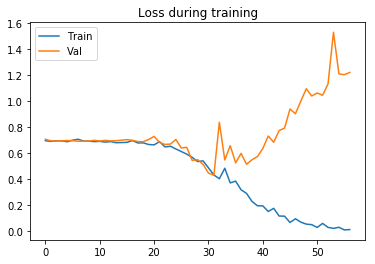

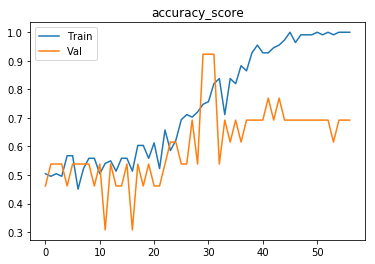

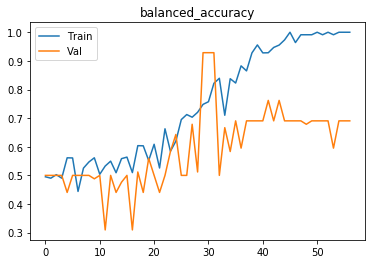

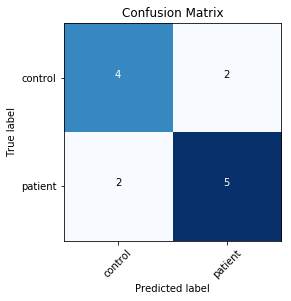

Finished outer fold.
{'final_acc': 0.761904761904762, 'best_acc': 0.8571428571428572, 'final_iter': 55, 'best_iter': 53, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 1
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69466
[0,    10] loss: 0.70134
[0,    15] loss: 0.70354
Time elapsed: 0h:0m:2s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.39 %
val accuracy_score: 38.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.698434
[1,     5] loss: 0.69041
[1,    10] loss: 0.70539
[1,    15] loss: 0.69501
Time elapsed: 0h:0m:5s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.49 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.686872
[2,     5] loss: 0.68731
[2,    10] loss: 0.68323
[2,    15] loss: 0.71246
Time elapsed: 0h:0m:7s
train accur

[32,    15] loss: 0.34572
Time elapsed: 0h:1m:32s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.56 %
val accuracy_score: 69.23 %
val balanced_accuracy: 60.00 %
Val loss: 0.522615
[33,     5] loss: 0.49998
[33,    10] loss: 0.44985
[33,    15] loss: 0.46463
Time elapsed: 0h:1m:35s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.64 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.495098
[34,     5] loss: 0.36988
[34,    10] loss: 0.53061
[34,    15] loss: 0.45194
Time elapsed: 0h:1m:37s
train accuracy_score: 79.28 %
train balanced_accuracy: 78.80 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.50 %
Val loss: 0.545805
[35,     5] loss: 0.46187
[35,    10] loss: 0.47382
[35,    15] loss: 0.37067
Time elapsed: 0h:1m:40s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.14 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.50 %
Val loss: 0.444616
[36,     5] loss: 0.56258
[36,    10] loss: 0.35609
[36,    15] loss: 0.51642
Ti

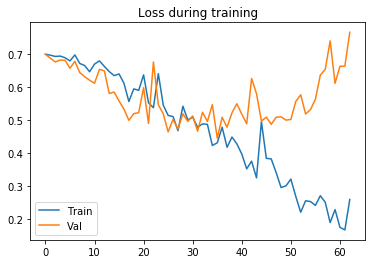

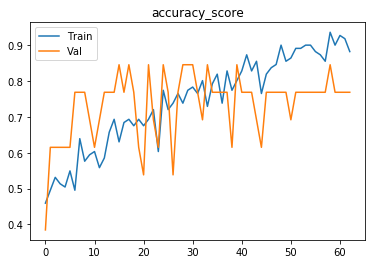

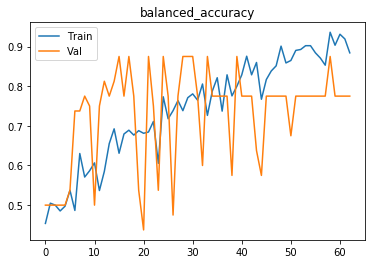

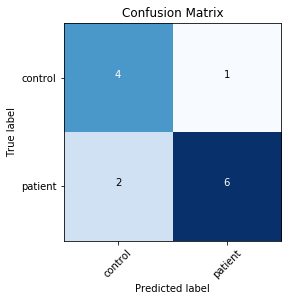

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.67724
[0,    10] loss: 0.71875
[0,    15] loss: 0.69498
Time elapsed: 0h:0m:2s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.685032
[1,     5] loss: 0.68420
[1,    10] loss: 0.69274
[1,    15] loss: 0.70017
Time elapsed: 0h:0m:5s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.679629
[2,     5] loss: 0.69108
[2,    10] loss: 0.68426
[2,    15] loss: 0.69989
Time elapsed: 0h:0m:7s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.686178
[3,     5] loss: 0.69164
[3,    10] loss: 0.70020
[3,    15] loss: 0.68637
Time elapsed: 0h:0m:10s
train accuracy_score: 51.35 %
train balanced_accur

Time elapsed: 0h:1m:35s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.03 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.508924
[34,     5] loss: 0.41575
[34,    10] loss: 0.24905
[34,    15] loss: 0.11838
Time elapsed: 0h:1m:38s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.37 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.425668
[35,     5] loss: 0.29349
[35,    10] loss: 0.27908
[35,    15] loss: 0.23505
Time elapsed: 0h:1m:41s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.41 %
val accuracy_score: 76.92 %
val balanced_accuracy: 81.25 %
Val loss: 0.527225
[36,     5] loss: 0.26890
[36,    10] loss: 0.19982
[36,    15] loss: 0.36147
Time elapsed: 0h:1m:44s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.34 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.440691
[37,     5] loss: 0.32636
[37,    10] loss: 0.19127
[37,    15] loss: 0.15649
Time elapsed: 0h:1m:46s
trai

[67,    10] loss: 0.04193
[67,    15] loss: 0.00987
Time elapsed: 0h:3m:11s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.375078
[68,     5] loss: 0.02647
[68,    10] loss: 0.00446
[68,    15] loss: 0.01294
Time elapsed: 0h:3m:13s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 81.25 %
Val loss: 0.911321
Early stopping in epoch 69
Total time elapsed: 0h:3m:14s
Writing model to disk...
Best result during training: 0.94. Saving model..
Finished inner fold.


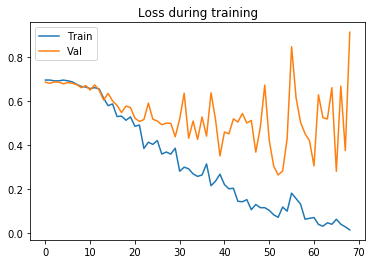

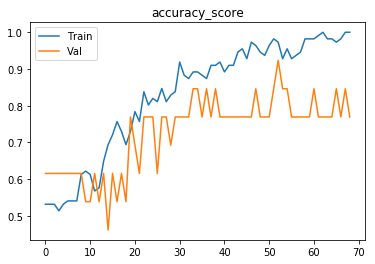

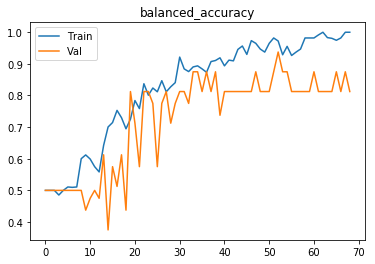

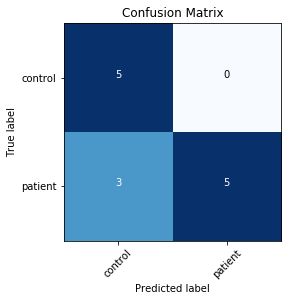

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69247
[0,    10] loss: 0.70342
[0,    15] loss: 0.71232
[0,    20] loss: 0.69028
[0,    25] loss: 0.69342
Time elapsed: 0h:0m:3s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.75 %
val accuracy_score: 38.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.694797
[1,     5] loss: 0.69400
[1,    10] loss: 0.69858
[1,    15] loss: 0.70116
[1,    20] loss: 0.69246
[1,    25] loss: 0.69250
Time elapsed: 0h:0m:7s
train accuracy_score: 45.95 %
train balanced_accuracy: 44.13 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.691229
[2,     5] loss: 0.69770
[2,    10] loss: 0.68709
[2,    15] loss: 0.69316
[2,    20] loss: 0.70075
[2,    25] loss: 0.68584
Time elapsed: 0h:0m:11s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.15 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.68595

val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.476005
[28,     5] loss: 0.52614
[28,    10] loss: 0.26466
[28,    15] loss: 0.29824
[28,    20] loss: 0.46469
[28,    25] loss: 0.40024
Time elapsed: 0h:1m:53s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.02 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.577451
[29,     5] loss: 0.43948
[29,    10] loss: 0.35165
[29,    15] loss: 0.43738
[29,    20] loss: 0.47527
[29,    25] loss: 0.52741
Time elapsed: 0h:1m:57s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.52 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.523318
[30,     5] loss: 0.27687
[30,    10] loss: 0.59549
[30,    15] loss: 0.32663
[30,    20] loss: 0.33199
[30,    25] loss: 0.33083
Time elapsed: 0h:2m:1s
train accuracy_score: 80.18 %
train balanced_accuracy: 79.99 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.579386
[31,     5] loss: 0.51230
[31,    10] 

val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.885159
[56,     5] loss: 0.02826
[56,    10] loss: 0.01357
[56,    15] loss: 0.01268
[56,    20] loss: 0.01589
[56,    25] loss: 0.01231
Time elapsed: 0h:3m:44s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.899981
[57,     5] loss: 0.02603
[57,    10] loss: 0.00789
[57,    15] loss: 0.01747
[57,    20] loss: 0.01228
[57,    25] loss: 0.04658
Time elapsed: 0h:3m:48s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.876491
[58,     5] loss: 0.01694
[58,    10] loss: 0.02002
[58,    15] loss: 0.01396
[58,    20] loss: 0.01625
[58,    25] loss: 0.02039
Time elapsed: 0h:3m:52s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.893546
[59,     5] loss: 0.01282
[59, 

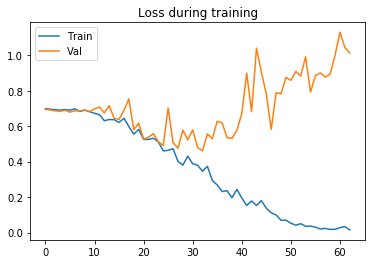

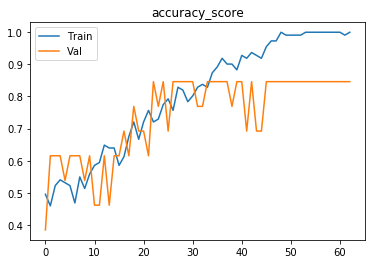

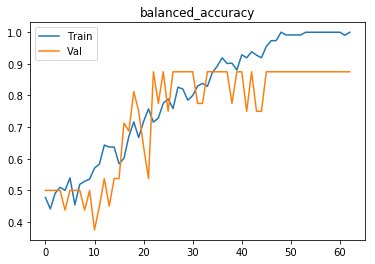

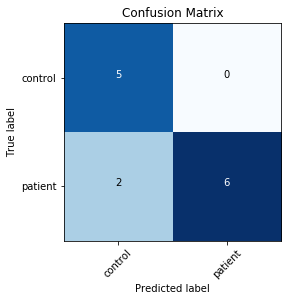

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69554
Time elapsed: 0h:0m:2s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.14 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.687080
[1,     5] loss: 0.69607
Time elapsed: 0h:0m:5s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.679316
[2,     5] loss: 0.69510
Time elapsed: 0h:0m:8s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.675133
[3,     5] loss: 0.69001
Time elapsed: 0h:0m:11s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.674903
[4,     5] loss: 0.69838
Time elapsed: 0h:0m:14s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.0

val accuracy_score: 53.85 %
val balanced_accuracy: 43.75 %
Val loss: 0.593091
[43,     5] loss: 0.52956
Time elapsed: 0h:2m:15s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.03 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.601923
[44,     5] loss: 0.46937
Time elapsed: 0h:2m:18s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.07 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.538692
[45,     5] loss: 0.54363
Time elapsed: 0h:2m:21s
train accuracy_score: 78.38 %
train balanced_accuracy: 79.20 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.517044
[46,     5] loss: 0.49081
Time elapsed: 0h:2m:24s
train accuracy_score: 75.68 %
train balanced_accuracy: 74.84 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.620033
[47,     5] loss: 0.52394
Time elapsed: 0h:2m:27s
train accuracy_score: 73.87 %
train balanced_accuracy: 74.63 %
val accuracy_score: 61.54 %
val balanced_accu

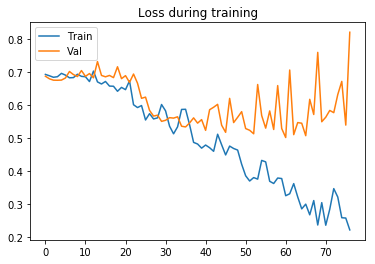

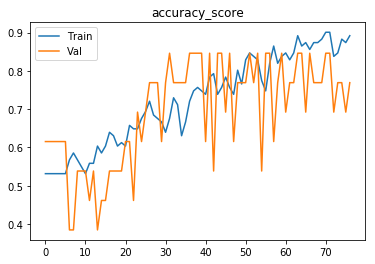

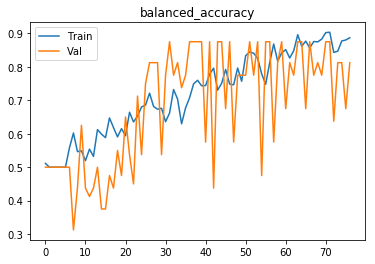

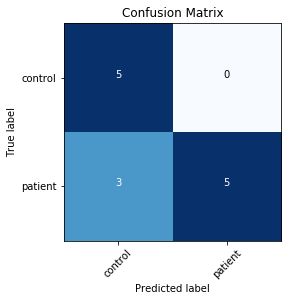

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69332
[0,    10] loss: 0.69517
[0,    15] loss: 0.69835
[0,    20] loss: 0.69431
[0,    25] loss: 0.69096
Time elapsed: 0h:0m:2s
train accuracy_score: 53.15 %
train balanced_accuracy: 53.31 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.688760
[1,     5] loss: 0.69275
[1,    10] loss: 0.69309
[1,    15] loss: 0.69076
[1,    20] loss: 0.69456
[1,    25] loss: 0.69215
Time elapsed: 0h:0m:6s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.27 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.683709
[2,     5] loss: 0.71060
[2,    10] loss: 0.69337
[2,    15] loss: 0.69226
[2,    20] loss: 0.69256
[2,    25] loss: 0.69025
Time elapsed: 0h:0m:9s
train accuracy_score: 46.85 %
train balanced_accuracy: 44.98 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.689202


val accuracy_score: 76.92 %
val balanced_accuracy: 81.25 %
Val loss: 0.539675
[28,     5] loss: 0.51928
[28,    10] loss: 0.41651
[28,    15] loss: 0.41141
[28,    20] loss: 0.43994
[28,    25] loss: 0.45734
Time elapsed: 0h:1m:36s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.63 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.508441
[29,     5] loss: 0.45738
[29,    10] loss: 0.36762
[29,    15] loss: 0.39991
[29,    20] loss: 0.40996
[29,    25] loss: 0.65834
Time elapsed: 0h:1m:39s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.48 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.498017
[30,     5] loss: 0.24611
[30,    10] loss: 0.38920
[30,    15] loss: 0.43805
[30,    20] loss: 0.73179
[30,    25] loss: 0.56725
Time elapsed: 0h:1m:43s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.33 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.25 %
Val loss: 0.503592
[31,     5] loss: 0.34838
[31,    10]

val accuracy_score: 76.92 %
val balanced_accuracy: 81.25 %
Val loss: 0.740296
[56,     5] loss: 0.28782
[56,    10] loss: 0.15647
[56,    15] loss: 0.09201
[56,    20] loss: 0.40398
[56,    25] loss: 0.26614
Time elapsed: 0h:3m:9s
train accuracy_score: 90.99 %
train balanced_accuracy: 91.07 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.614606
[57,     5] loss: 0.29327
[57,    10] loss: 0.21272
[57,    15] loss: 0.26401
[57,    20] loss: 0.08973
[57,    25] loss: 0.18963
Time elapsed: 0h:3m:13s
train accuracy_score: 90.99 %
train balanced_accuracy: 90.96 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.50 %
Val loss: 0.678500
[58,     5] loss: 0.26608
[58,    10] loss: 0.23293
[58,    15] loss: 0.13432
[58,    20] loss: 0.20060
[58,    25] loss: 0.41086
Time elapsed: 0h:3m:16s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.49 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.657392
[59,     5] loss: 0.22197
[59,    10] 

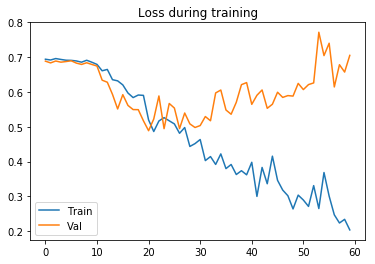

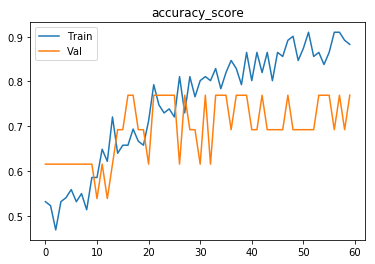

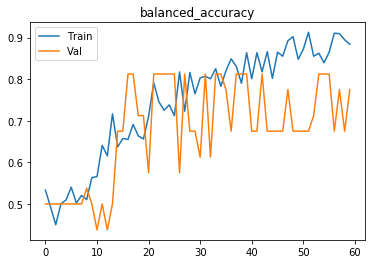

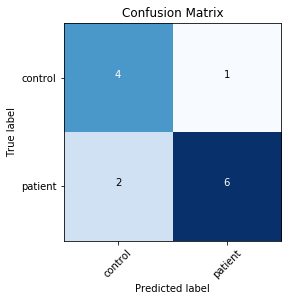

Finished outer fold.
{'final_acc': 0.875, 'best_acc': 0.875, 'final_iter': 63, 'best_iter': 63, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}
###### Starting outer fold 2
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.70339
[0,    10] loss: 0.69061
[0,    15] loss: 0.69323
[0,    20] loss: 0.70095
[0,    25] loss: 0.69348
Time elapsed: 0h:0m:2s
train accuracy_score: 42.34 %
train balanced_accuracy: 42.60 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695523
[1,     5] loss: 0.69320
[1,    10] loss: 0.69625
[1,    15] loss: 0.70251
[1,    20] loss: 0.69134
[1,    25] loss: 0.68849
Time elapsed: 0h:0m:6s
train accuracy_score: 45.05 %
train balanced_accuracy: 45.23 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692637
[2,     5] loss: 0.69469
[2,    10

val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.460666
[27,     5] loss: 0.58469
[27,    10] loss: 0.62818
[27,    15] loss: 0.58807
[27,    20] loss: 0.45775
[27,    25] loss: 0.57337
Time elapsed: 0h:1m:32s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.23 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.454027
[28,     5] loss: 0.59676
[28,    10] loss: 0.52285
[28,    15] loss: 0.59329
[28,    20] loss: 0.41936
[28,    25] loss: 0.56164
Time elapsed: 0h:1m:35s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.52 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.452292
[29,     5] loss: 0.50777
[29,    10] loss: 0.39752
[29,    15] loss: 0.52483
[29,    20] loss: 0.56327
[29,    25] loss: 0.82080
Time elapsed: 0h:1m:38s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.91 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.459726
[30,     5] loss: 0.54595
[30,    10]

val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.386130
[55,     5] loss: 0.19602
[55,    10] loss: 0.22907
[55,    15] loss: 0.38647
[55,    20] loss: 0.32187
[55,    25] loss: 0.19356
Time elapsed: 0h:3m:4s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.08 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.230279
[56,     5] loss: 0.18309
[56,    10] loss: 0.26330
[56,    15] loss: 0.28373
[56,    20] loss: 0.20605
[56,    25] loss: 0.22557
Time elapsed: 0h:3m:8s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.11 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.256207
[57,     5] loss: 0.25967
[57,    10] loss: 0.20164
[57,    15] loss: 0.32408
[57,    20] loss: 0.25793
[57,    25] loss: 0.18855
Time elapsed: 0h:3m:11s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.16 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.128187
[58,     5] loss: 0.27840
[58,    10]

val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.178289
[83,     5] loss: 0.01434
[83,    10] loss: 0.00559
[83,    15] loss: 0.09250
[83,    20] loss: 0.02138
[83,    25] loss: 0.07940
Time elapsed: 0h:4m:37s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.20 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.264969
[84,     5] loss: 0.04348
[84,    10] loss: 0.01856
[84,    15] loss: 0.05588
[84,    20] loss: 0.01618
[84,    25] loss: 0.10180
Time elapsed: 0h:4m:41s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.18 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.124315
[85,     5] loss: 0.01151
[85,    10] loss: 0.05214
[85,    15] loss: 0.01723
[85,    20] loss: 0.02383
[85,    25] loss: 0.05011
Time elapsed: 0h:4m:44s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.166709
[86,     5] loss: 0.02799
[86,    1

[110,    20] loss: 0.03473
[110,    25] loss: 0.00134
Time elapsed: 0h:6m:7s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.09 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.313473
[111,     5] loss: 0.02343
[111,    10] loss: 0.01310
[111,    15] loss: 0.00154
[111,    20] loss: 0.00186
[111,    25] loss: 0.00154
Time elapsed: 0h:6m:10s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.584600
[112,     5] loss: 0.01002
[112,    10] loss: 0.00484
[112,    15] loss: 0.00165
[112,    20] loss: 0.00790
[112,    25] loss: 0.00775
Time elapsed: 0h:6m:14s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.392835
[113,     5] loss: 0.01032
[113,    10] loss: 0.00063
[113,    15] loss: 0.00347
[113,    20] loss: 0.00183
[113,    25] loss: 0.00430
Time elapsed: 0h:6m:17s
train accuracy_scor

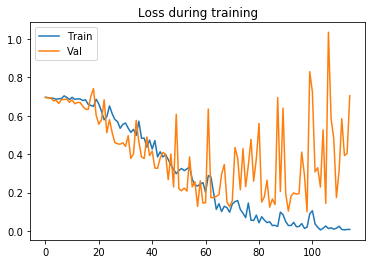

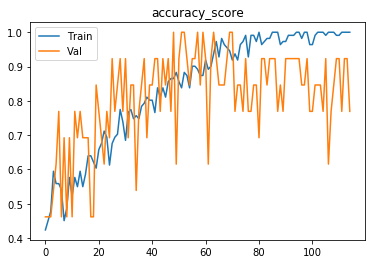

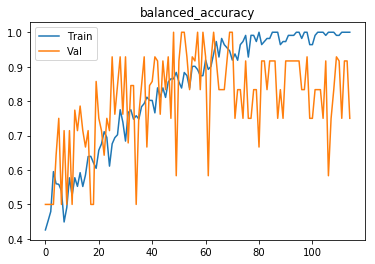

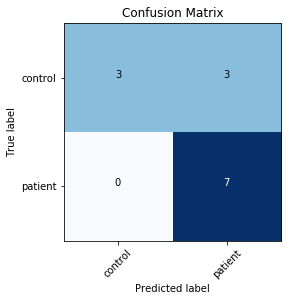

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69903
[0,    10] loss: 0.69542
[0,    15] loss: 0.69895
Time elapsed: 0h:0m:2s
train accuracy_score: 45.95 %
train balanced_accuracy: 46.07 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693514
[1,     5] loss: 0.70484
[1,    10] loss: 0.69547
[1,    15] loss: 0.68816
Time elapsed: 0h:0m:5s
train accuracy_score: 44.14 %
train balanced_accuracy: 44.43 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696053
[2,     5] loss: 0.69705
[2,    10] loss: 0.68034
[2,    15] loss: 0.70629
Time elapsed: 0h:0m:8s
train accuracy_score: 48.65 %
train balanced_accuracy: 49.07 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696679
[3,     5] loss: 0.69659
[3,    10] loss: 0.68691
[3,    15] loss: 0.68893
Time elapsed: 0h:0m:11s
train accuracy_score: 56.76 %
train balanced_accur

Time elapsed: 0h:1m:36s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.51 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.391372
[34,     5] loss: 0.50822
[34,    10] loss: 0.61067
[34,    15] loss: 0.52432
Time elapsed: 0h:1m:39s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.68 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.470787
[35,     5] loss: 0.50265
[35,    10] loss: 0.62396
[35,    15] loss: 0.49973
Time elapsed: 0h:1m:42s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.94 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.362883
[36,     5] loss: 0.51844
[36,    10] loss: 0.55805
[36,    15] loss: 0.37703
Time elapsed: 0h:1m:45s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.44 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.348812
[37,     5] loss: 0.46707
[37,    10] loss: 0.41718
[37,    15] loss: 0.45544
Time elapsed: 0h:1m:48s
trai

[67,    10] loss: 0.17582
[67,    15] loss: 0.18291
Time elapsed: 0h:3m:15s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.70 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.274739
[68,     5] loss: 0.20673
[68,    10] loss: 0.14289
[68,    15] loss: 0.13501
Time elapsed: 0h:3m:18s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.70 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.363986
[69,     5] loss: 0.24715
[69,    10] loss: 0.18971
[69,    15] loss: 0.13889
Time elapsed: 0h:3m:21s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.61 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.292655
[70,     5] loss: 0.14189
[70,    10] loss: 0.31725
[70,    15] loss: 0.19055
Time elapsed: 0h:3m:24s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.79 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.222503
[71,     5] loss: 0.07645
[71,    10] loss: 0.09224
[7

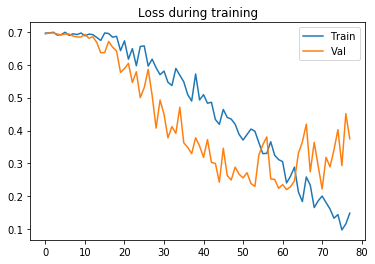

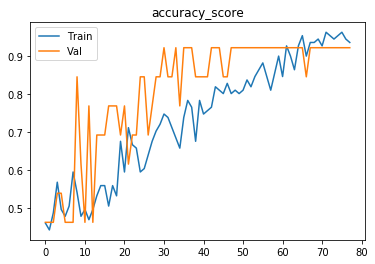

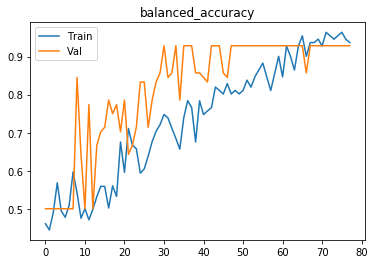

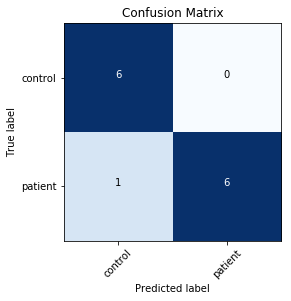

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69818
[0,    10] loss: 0.69773
[0,    15] loss: 0.69983
Time elapsed: 0h:0m:3s
train accuracy_score: 43.24 %
train balanced_accuracy: 43.25 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691502
[1,     5] loss: 0.69115
[1,    10] loss: 0.69612
[1,    15] loss: 0.68824
Time elapsed: 0h:0m:6s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690792
[2,     5] loss: 0.69157
[2,    10] loss: 0.69056
[2,    15] loss: 0.69237
Time elapsed: 0h:0m:10s
train accuracy_score: 55.86 %
train balanced_accuracy: 55.99 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692260
[3,     5] loss: 0.70841
[3,    10] loss: 0.70076
[3,    15] loss: 0.69710
Time elapsed: 0h:0m:13s
train accuracy_score: 43.24 %
train balanced_accu

Time elapsed: 0h:2m:0s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.72 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.469939
[34,     5] loss: 0.54729
[34,    10] loss: 0.45095
[34,    15] loss: 0.50421
Time elapsed: 0h:2m:4s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.68 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.483504
[35,     5] loss: 0.50688
[35,    10] loss: 0.58400
[35,    15] loss: 0.57938
Time elapsed: 0h:2m:7s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.71 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.469942
[36,     5] loss: 0.40901
[36,    10] loss: 0.55237
[36,    15] loss: 0.48718
Time elapsed: 0h:2m:11s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.00 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.594415
[37,     5] loss: 0.64469
[37,    10] loss: 0.46300
[37,    15] loss: 0.54606
Time elapsed: 0h:2m:14s
train a

[67,    10] loss: 0.12484
[67,    15] loss: 0.17100
Time elapsed: 0h:4m:1s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.29 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.314878
[68,     5] loss: 0.07410
[68,    10] loss: 0.14248
[68,    15] loss: 0.02062
Time elapsed: 0h:4m:4s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.29 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.358116
[69,     5] loss: 0.03007
[69,    10] loss: 0.12578
[69,    15] loss: 0.07847
Time elapsed: 0h:4m:8s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.21 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.434352
[70,     5] loss: 0.06452
[70,    10] loss: 0.03955
[70,    15] loss: 0.04094
Time elapsed: 0h:4m:11s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.479825
[71,     5] loss: 0.08032
[71,    10] loss: 0.02516
[71

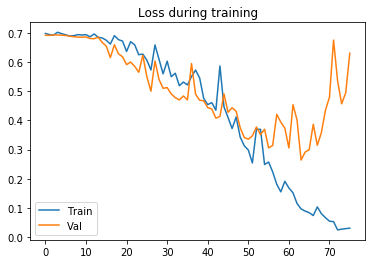

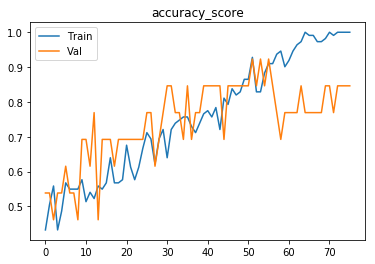

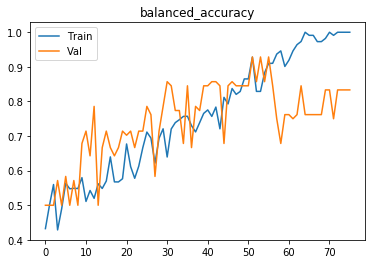

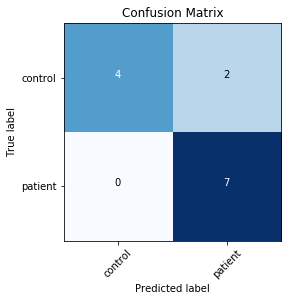

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69348
[0,    10] loss: 0.70601
[0,    15] loss: 0.69096
[0,    20] loss: 0.70055
[0,    25] loss: 0.69333
Time elapsed: 0h:0m:3s
train accuracy_score: 40.54 %
train balanced_accuracy: 40.78 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693691
[1,     5] loss: 0.69088
[1,    10] loss: 0.68914
[1,    15] loss: 0.70571
[1,    20] loss: 0.69104
[1,    25] loss: 0.69797
Time elapsed: 0h:0m:7s
train accuracy_score: 43.24 %
train balanced_accuracy: 43.54 %
val accuracy_score: 53.85 %
val balanced_accuracy: 57.14 %
Val loss: 0.692226
[2,     5] loss: 0.69353
[2,    10] loss: 0.68811
[2,    15] loss: 0.69753
[2,    20] loss: 0.72257
[2,    25] loss: 0.69069
Time elapsed: 0h:0m:11s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.19 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.69397

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.486218
[28,     5] loss: 0.46226
[28,    10] loss: 0.42858
[28,    15] loss: 0.54804
[28,    20] loss: 0.25406
[28,    25] loss: 0.68094
Time elapsed: 0h:1m:54s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.60 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.465666
[29,     5] loss: 0.50657
[29,    10] loss: 0.46449
[29,    15] loss: 0.55224
[29,    20] loss: 0.55300
[29,    25] loss: 0.67750
Time elapsed: 0h:1m:58s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.88 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.506948
[30,     5] loss: 0.53260
[30,    10] loss: 0.37453
[30,    15] loss: 0.37566
[30,    20] loss: 0.38367
[30,    25] loss: 0.62815
Time elapsed: 0h:2m:2s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.61 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.450825
[31,     5] loss: 0.54937
[31,    10] 

val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.335393
[56,     5] loss: 0.04592
[56,    10] loss: 0.08737
[56,    15] loss: 0.01947
[56,    20] loss: 0.03269
[56,    25] loss: 0.09807
Time elapsed: 0h:3m:46s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.09 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.480755
[57,     5] loss: 0.03353
[57,    10] loss: 0.04829
[57,    15] loss: 0.05436
[57,    20] loss: 0.13526
[57,    25] loss: 0.02469
Time elapsed: 0h:3m:50s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.20 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.464977
[58,     5] loss: 0.02032
[58,    10] loss: 0.05609
[58,    15] loss: 0.05252
[58,    20] loss: 0.04024
[58,    25] loss: 0.02486
Time elapsed: 0h:3m:54s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.402038
[59,     5] loss: 0.03990
[59,    1

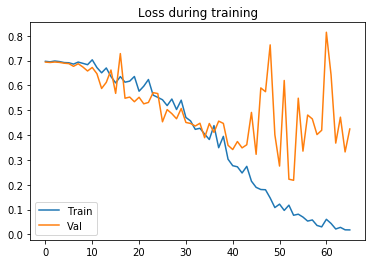

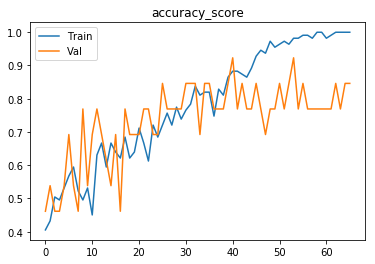

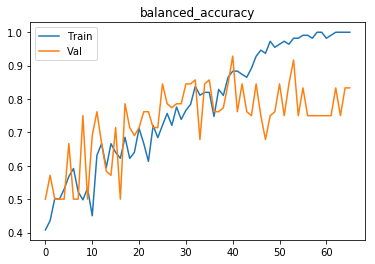

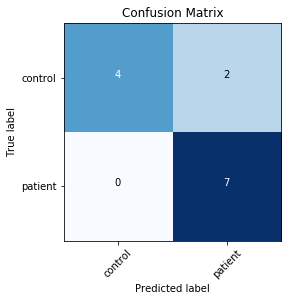

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69353
Time elapsed: 0h:0m:2s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691183
[1,     5] loss: 0.69307
Time elapsed: 0h:0m:5s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692190
[2,     5] loss: 0.69489
Time elapsed: 0h:0m:8s
train accuracy_score: 43.24 %
train balanced_accuracy: 43.12 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.692727
[3,     5] loss: 0.69192
Time elapsed: 0h:0m:12s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.11 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691071
[4,     5] loss: 0.69193
Time elapsed: 0h:0m:15s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.00

val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.549978
[43,     5] loss: 0.59267
Time elapsed: 0h:2m:18s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.40 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.505580
[44,     5] loss: 0.58221
Time elapsed: 0h:2m:22s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.01 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.510328
[45,     5] loss: 0.58211
Time elapsed: 0h:2m:25s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.75 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.481385
[46,     5] loss: 0.65024
Time elapsed: 0h:2m:28s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.48 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.602831
[47,     5] loss: 0.62200
Time elapsed: 0h:2m:31s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.82 %
val accuracy_score: 76.92 %
val balanced_accu

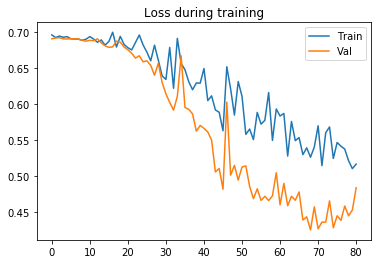

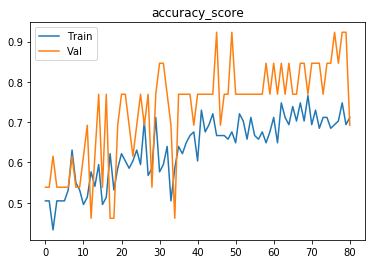

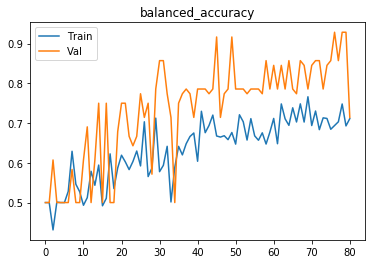

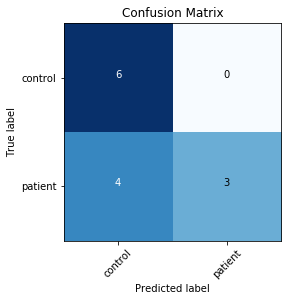

Finished outer fold.
{'final_acc': 0.9285714285714286, 'best_acc': 0.9285714285714286, 'final_iter': 78, 'best_iter': 78, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1}
###### Starting outer fold 3
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.68786
[0,    10] loss: 0.69101
[0,    15] loss: 0.71920
Time elapsed: 0h:0m:2s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.16 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697334
[1,     5] loss: 0.69687
[1,    10] loss: 0.69178
[1,    15] loss: 0.69334
Time elapsed: 0h:0m:5s
train accuracy_score: 48.65 %
train balanced_accuracy: 48.31 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692642
[2,     5] loss: 0.69437
[2,    10] loss: 0.69272
[2,    15] loss: 0.69122
Time elapsed: 0h:0m:7s
train accur

[32,    15] loss: 0.72931
Time elapsed: 0h:1m:27s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.82 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.441418
[33,     5] loss: 0.61771
[33,    10] loss: 0.48034
[33,    15] loss: 0.64637
Time elapsed: 0h:1m:29s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.56 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.465994
[34,     5] loss: 0.56790
[34,    10] loss: 0.63311
[34,    15] loss: 0.63116
Time elapsed: 0h:1m:32s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.85 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.469080
[35,     5] loss: 0.57130
[35,    10] loss: 0.62696
[35,    15] loss: 0.51473
Time elapsed: 0h:1m:35s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.51 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.438145
[36,     5] loss: 0.58025
[36,    10] loss: 0.46061
[36,    15] loss: 0.60397
Ti

[66,     5] loss: 0.57682
[66,    10] loss: 0.46152
[66,    15] loss: 0.40506
Time elapsed: 0h:2m:57s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.66 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.303195
[67,     5] loss: 0.33489
[67,    10] loss: 0.61945
[67,    15] loss: 0.47139
Time elapsed: 0h:3m:0s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.29 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.313638
[68,     5] loss: 0.45458
[68,    10] loss: 0.38286
[68,    15] loss: 0.45206
Time elapsed: 0h:3m:3s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.68 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.323458
[69,     5] loss: 0.32366
[69,    10] loss: 0.50897
[69,    15] loss: 0.46208
Time elapsed: 0h:3m:5s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.22 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.407010
[70,     5] loss: 0.39926
[70, 

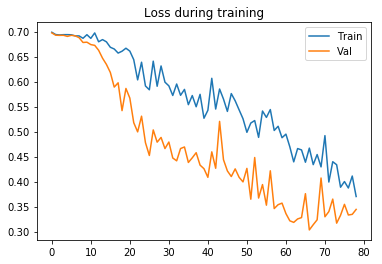

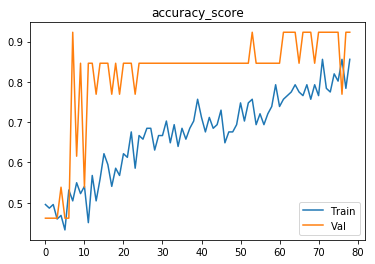

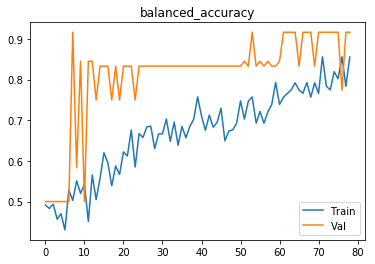

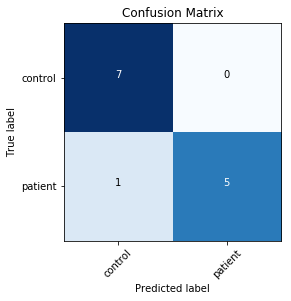

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69914
Time elapsed: 0h:0m:1s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690401
[1,     5] loss: 0.69481
Time elapsed: 0h:0m:4s
train accuracy_score: 48.65 %
train balanced_accuracy: 49.06 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691614
[2,     5] loss: 0.69198
Time elapsed: 0h:0m:6s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.63 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690296
[3,     5] loss: 0.69889
Time elapsed: 0h:0m:8s
train accuracy_score: 44.14 %
train balanced_accuracy: 43.86 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694102
[4,     5] loss: 0.69388
Time elapsed: 0h:0m:10s
train accuracy_score: 48.65 %
train balanced_accuracy: 48.81

val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.452539
[43,     5] loss: 0.63339
Time elapsed: 0h:1m:39s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.41 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.428569
[44,     5] loss: 0.58055
Time elapsed: 0h:1m:41s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.45 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.383528
[45,     5] loss: 0.60967
Time elapsed: 0h:1m:43s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.77 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.416608
[46,     5] loss: 0.53218
Time elapsed: 0h:1m:46s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.86 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.427178
[47,     5] loss: 0.59870
Time elapsed: 0h:1m:48s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.50 %
val accuracy_score: 84.62 %
val balanced_accu

val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.302677
[86,     5] loss: 0.42669
Time elapsed: 0h:3m:16s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.44 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.321708
[87,     5] loss: 0.37160
Time elapsed: 0h:3m:18s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.58 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.283171
[88,     5] loss: 0.28824
Time elapsed: 0h:3m:20s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.87 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.277624
[89,     5] loss: 0.30831
Time elapsed: 0h:3m:22s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.06 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.334713
[90,     5] loss: 0.24523
Time elapsed: 0h:3m:24s
train accuracy_score: 90.99 %
train balanced_accuracy: 91.04 %
val accuracy_score: 84.62 %
val balanced_accu

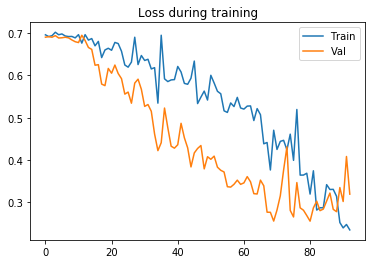

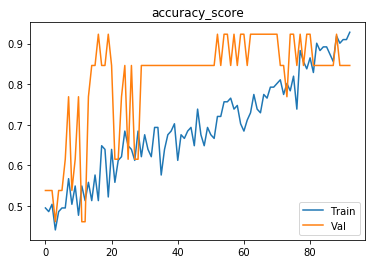

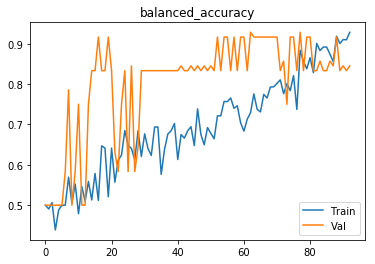

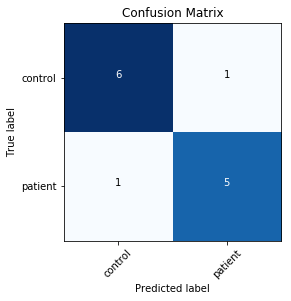

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69602
[0,    10] loss: 0.69852
[0,    15] loss: 0.68514
Time elapsed: 0h:0m:2s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691028
[1,     5] loss: 0.68989
[1,    10] loss: 0.69602
[1,    15] loss: 0.69552
Time elapsed: 0h:0m:6s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690266
[2,     5] loss: 0.69335
[2,    10] loss: 0.69001
[2,    15] loss: 0.69230
Time elapsed: 0h:0m:9s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.84 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689328
[3,     5] loss: 0.69953
[3,    10] loss: 0.69403
[3,    15] loss: 0.69135
Time elapsed: 0h:0m:12s
train accuracy_score: 46.85 %
train balanced_accura

Time elapsed: 0h:1m:53s
train accuracy_score: 63.96 %
train balanced_accuracy: 64.03 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.641356
[34,     5] loss: 0.68087
[34,    10] loss: 0.64140
[34,    15] loss: 0.71848
Time elapsed: 0h:1m:57s
train accuracy_score: 56.76 %
train balanced_accuracy: 56.80 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.546442
[35,     5] loss: 0.62520
[35,    10] loss: 0.70158
[35,    15] loss: 0.61130
Time elapsed: 0h:2m:0s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.85 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.545721
[36,     5] loss: 0.57613
[36,    10] loss: 0.66628
[36,    15] loss: 0.66739
Time elapsed: 0h:2m:3s
train accuracy_score: 58.56 %
train balanced_accuracy: 58.57 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.527922
[37,     5] loss: 0.63432
[37,    10] loss: 0.56319
[37,    15] loss: 0.58483
Time elapsed: 0h:2m:7s
train a

[67,    10] loss: 0.50319
[67,    15] loss: 0.47532
Time elapsed: 0h:3m:48s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.38 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.352528
[68,     5] loss: 0.37017
[68,    10] loss: 0.40222
[68,    15] loss: 0.40453
Time elapsed: 0h:3m:51s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.78 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.337533
[69,     5] loss: 0.32942
[69,    10] loss: 0.44527
[69,    15] loss: 0.37810
Time elapsed: 0h:3m:55s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.57 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.348716
[70,     5] loss: 0.33465
[70,    10] loss: 0.41689
[70,    15] loss: 0.41315
Time elapsed: 0h:3m:58s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.19 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.291597
[71,     5] loss: 0.34412
[71,    10] loss: 0.38261
[7

[101,     5] loss: 0.07224
[101,    10] loss: 0.23097
[101,    15] loss: 0.22158
Time elapsed: 0h:5m:42s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.72 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.252448
[102,     5] loss: 0.17907
[102,    10] loss: 0.14138
[102,    15] loss: 0.09273
Time elapsed: 0h:5m:46s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.52 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.213937
[103,     5] loss: 0.15506
[103,    10] loss: 0.19956
[103,    15] loss: 0.11917
Time elapsed: 0h:5m:49s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.72 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.236123
[104,     5] loss: 0.22149
[104,    10] loss: 0.09576
[104,    15] loss: 0.15951
Time elapsed: 0h:5m:52s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.70 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.235270
[105,     5] los

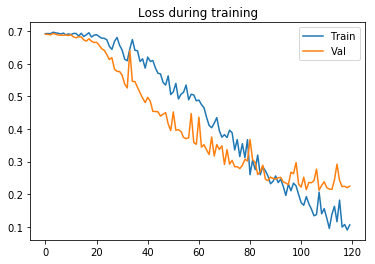

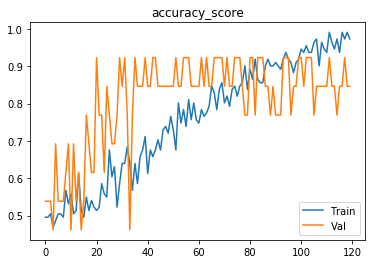

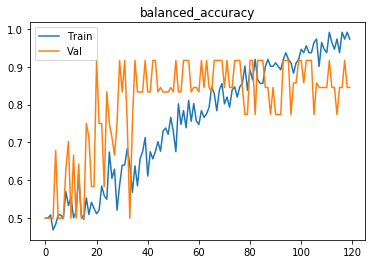

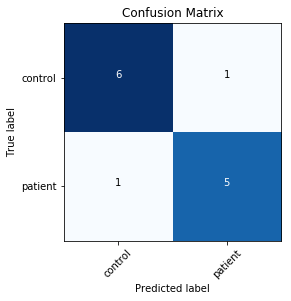

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69456
[0,    10] loss: 0.69970
[0,    15] loss: 0.70012
Time elapsed: 0h:0m:2s
train accuracy_score: 44.14 %
train balanced_accuracy: 44.25 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691284
[1,     5] loss: 0.69328
[1,    10] loss: 0.69290
[1,    15] loss: 0.69289
Time elapsed: 0h:0m:6s
train accuracy_score: 54.05 %
train balanced_accuracy: 54.09 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.691805
[2,     5] loss: 0.68962
[2,    10] loss: 0.69205
[2,    15] loss: 0.69455
Time elapsed: 0h:0m:9s
train accuracy_score: 55.86 %
train balanced_accuracy: 55.75 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.691668
[3,     5] loss: 0.69232
[3,    10] loss: 0.69022
[3,    15] loss: 0.69024
Time elapsed: 0h:0m:13s
train accuracy_score: 55.86 %
train balanced_accura

Time elapsed: 0h:1m:54s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.72 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.576305
[34,     5] loss: 0.61935
[34,    10] loss: 0.66573
[34,    15] loss: 0.57946
Time elapsed: 0h:1m:57s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.99 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.534041
[35,     5] loss: 0.64460
[35,    10] loss: 0.59763
[35,    15] loss: 0.69196
Time elapsed: 0h:2m:0s
train accuracy_score: 57.66 %
train balanced_accuracy: 57.60 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.537280
[36,     5] loss: 0.69855
[36,    10] loss: 0.54985
[36,    15] loss: 0.62040
Time elapsed: 0h:2m:4s
train accuracy_score: 63.06 %
train balanced_accuracy: 63.04 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.520771
[37,     5] loss: 0.59309
[37,    10] loss: 0.75597
[37,    15] loss: 0.69359
Time elapsed: 0h:2m:7s
train a

[67,    10] loss: 0.43168
[67,    15] loss: 0.50998
Time elapsed: 0h:3m:48s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.27 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.409415
[68,     5] loss: 0.44568
[68,    10] loss: 0.49427
[68,    15] loss: 0.55639
Time elapsed: 0h:3m:52s
train accuracy_score: 72.07 %
train balanced_accuracy: 71.96 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.447682
[69,     5] loss: 0.57495
[69,    10] loss: 0.39316
[69,    15] loss: 0.59699
Time elapsed: 0h:3m:55s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.02 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.401219
[70,     5] loss: 0.52178
[70,    10] loss: 0.45135
[70,    15] loss: 0.43717
Time elapsed: 0h:3m:58s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.56 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.391123
[71,     5] loss: 0.52872
[71,    10] loss: 0.47573
[7

[101,     5] loss: 0.28302
[101,    10] loss: 0.20906
[101,    15] loss: 0.37149
Time elapsed: 0h:5m:44s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.20 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.402942
[102,     5] loss: 0.24403
[102,    10] loss: 0.26600
[102,    15] loss: 0.29770
Time elapsed: 0h:5m:47s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.48 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.700461
[103,     5] loss: 0.46604
[103,    10] loss: 0.31197
[103,    15] loss: 0.37377
Time elapsed: 0h:5m:51s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.87 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.502499
[104,     5] loss: 0.26595
[104,    10] loss: 0.16428
[104,    15] loss: 0.36281
Time elapsed: 0h:5m:54s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.15 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.387714
[105,     5] los

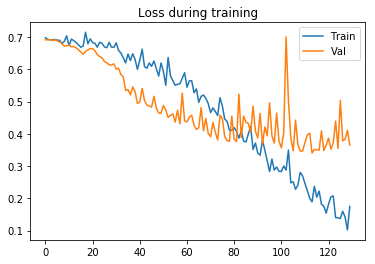

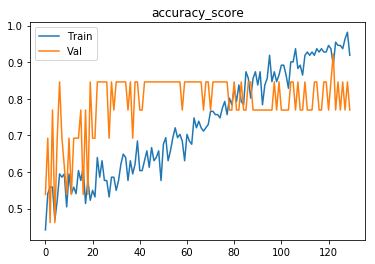

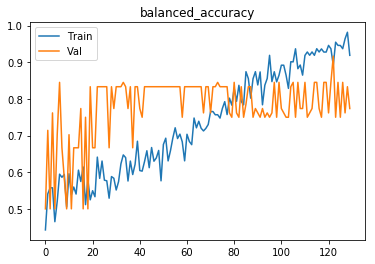

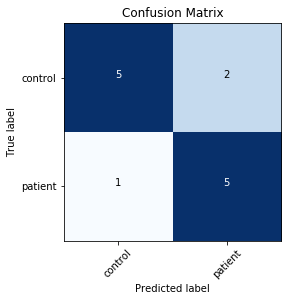

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69421
[0,    10] loss: 0.69777
[0,    15] loss: 0.69146
Time elapsed: 0h:0m:2s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.68 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.692448
[1,     5] loss: 0.69406
[1,    10] loss: 0.69235
[1,    15] loss: 0.69379
Time elapsed: 0h:0m:6s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.39 %
val accuracy_score: 61.54 %
val balanced_accuracy: 64.29 %
Val loss: 0.691827
[2,     5] loss: 0.69337
[2,    10] loss: 0.69055
[2,    15] loss: 0.69466
Time elapsed: 0h:0m:9s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.61 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692049
[3,     5] loss: 0.69047
[3,    10] loss: 0.69443
[3,    15] loss: 0.69529
Time elapsed: 0h:0m:13s
train accuracy_score: 48.65 %
train balanced_accura

Time elapsed: 0h:1m:54s
train accuracy_score: 61.26 %
train balanced_accuracy: 61.09 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.503764
[34,     5] loss: 0.65989
[34,    10] loss: 0.61534
[34,    15] loss: 0.60697
Time elapsed: 0h:1m:57s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.91 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.500095
[35,     5] loss: 0.66556
[35,    10] loss: 0.61300
[35,    15] loss: 0.57373
Time elapsed: 0h:2m:0s
train accuracy_score: 63.96 %
train balanced_accuracy: 64.07 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.486211
[36,     5] loss: 0.65159
[36,    10] loss: 0.57939
[36,    15] loss: 0.56497
Time elapsed: 0h:2m:4s
train accuracy_score: 63.96 %
train balanced_accuracy: 64.01 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.463118
[37,     5] loss: 0.55394
[37,    10] loss: 0.60712
[37,    15] loss: 0.61044
Time elapsed: 0h:2m:7s
train a

[67,    10] loss: 0.45760
[67,    15] loss: 0.41432
Time elapsed: 0h:3m:48s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.08 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.360303
[68,     5] loss: 0.54063
[68,    10] loss: 0.49139
[68,    15] loss: 0.35822
Time elapsed: 0h:3m:51s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.81 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.392865
[69,     5] loss: 0.45083
[69,    10] loss: 0.36428
[69,    15] loss: 0.44487
Time elapsed: 0h:3m:54s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.87 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.343711
[70,     5] loss: 0.37620
[70,    10] loss: 0.36222
[70,    15] loss: 0.41852
Time elapsed: 0h:3m:58s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.83 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.333038
[71,     5] loss: 0.52093
[71,    10] loss: 0.35413
[7

[101,     5] loss: 0.15526
[101,    10] loss: 0.19513
[101,    15] loss: 0.13297
Time elapsed: 0h:5m:42s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.82 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.281409
[102,     5] loss: 0.19067
[102,    10] loss: 0.16953
[102,    15] loss: 0.08248
Time elapsed: 0h:5m:45s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.59 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.314383
[103,     5] loss: 0.14076
[103,    10] loss: 0.23204
[103,    15] loss: 0.18533
Time elapsed: 0h:5m:49s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.10 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.302787
[104,     5] loss: 0.20868
[104,    10] loss: 0.15234
[104,    15] loss: 0.11059
Time elapsed: 0h:5m:52s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.59 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.292846
[105,     5] los

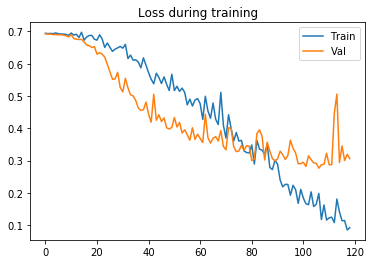

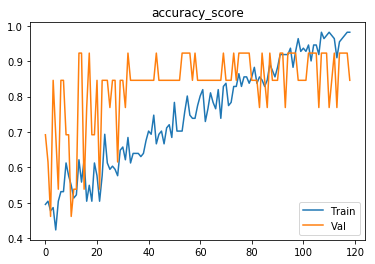

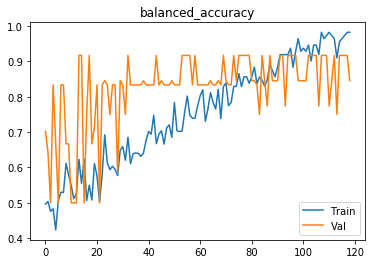

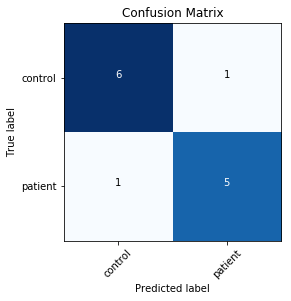

Finished outer fold.
{'final_acc': 0.9166666666666667, 'best_acc': 0.9166666666666667, 'final_iter': 79, 'best_iter': 79, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 0}
###### Starting outer fold 4
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69936
[0,    10] loss: 0.68707
[0,    15] loss: 0.68926
[0,    20] loss: 0.69739
[0,    25] loss: 0.69175
Time elapsed: 0h:0m:2s
train accuracy_score: 50.45 %
train balanced_accuracy: 47.55 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689982
[1,     5] loss: 0.71982
[1,    10] loss: 0.68498
[1,    15] loss: 0.68651
[1,    20] loss: 0.69354
[1,    25] loss: 0.66703
Time elapsed: 0h:0m:5s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691353
[2,     5

val accuracy_score: 46.15 %
val balanced_accuracy: 44.05 %
Val loss: 0.603852
[27,     5] loss: 0.57022
[27,    10] loss: 0.73819
[27,    15] loss: 0.57601
[27,    20] loss: 0.53408
[27,    25] loss: 0.58045
Time elapsed: 0h:1m:29s
train accuracy_score: 67.57 %
train balanced_accuracy: 66.62 %
val accuracy_score: 53.85 %
val balanced_accuracy: 51.19 %
Val loss: 0.604754
[28,     5] loss: 0.56830
[28,    10] loss: 0.48890
[28,    15] loss: 0.54314
[28,    20] loss: 0.41436
[28,    25] loss: 0.53355
Time elapsed: 0h:1m:32s
train accuracy_score: 71.17 %
train balanced_accuracy: 70.69 %
val accuracy_score: 53.85 %
val balanced_accuracy: 51.19 %
Val loss: 0.647900
[29,     5] loss: 0.52332
[29,    10] loss: 0.63796
[29,    15] loss: 0.58933
[29,    20] loss: 0.46648
[29,    25] loss: 0.34540
Time elapsed: 0h:1m:35s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.44 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.562614
[30,     5] loss: 0.45102
[30,    10]

val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.610499
[55,     5] loss: 0.12420
[55,    10] loss: 0.16156
[55,    15] loss: 0.25271
[55,    20] loss: 0.19913
[55,    25] loss: 0.37964
Time elapsed: 0h:3m:0s
train accuracy_score: 89.19 %
train balanced_accuracy: 88.97 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.682918
[56,     5] loss: 0.24874
[56,    10] loss: 0.12806
[56,    15] loss: 0.01916
[56,    20] loss: 0.23347
[56,    25] loss: 0.14014
Time elapsed: 0h:3m:3s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.39 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.623486
[57,     5] loss: 0.08606
[57,    10] loss: 0.13778
[57,    15] loss: 0.31270
[57,    20] loss: 0.20646
[57,    25] loss: 0.08262
Time elapsed: 0h:3m:6s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.58 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.690181
[58,     5] loss: 0.12861
[58,    10] lo

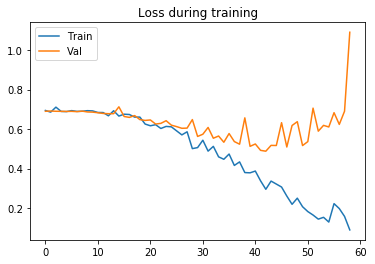

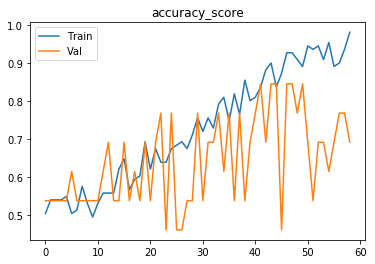

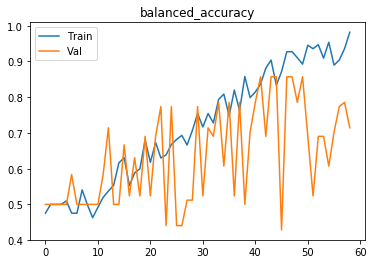

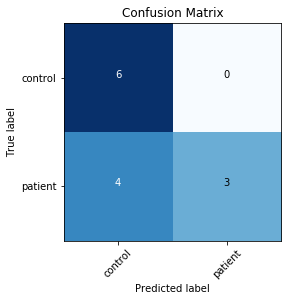

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69591
Time elapsed: 0h:0m:1s
train accuracy_score: 48.65 %
train balanced_accuracy: 45.88 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691415
[1,     5] loss: 0.69103
Time elapsed: 0h:0m:4s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690678
[2,     5] loss: 0.69399
Time elapsed: 0h:0m:6s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690273
[3,     5] loss: 0.69244
Time elapsed: 0h:0m:8s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690173
[4,     5] loss: 0.69758
Time elapsed: 0h:0m:11s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 

val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.653257
[43,     5] loss: 0.63610
Time elapsed: 0h:1m:43s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.44 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.636593
[44,     5] loss: 0.56729
Time elapsed: 0h:1m:45s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.98 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.643462
[45,     5] loss: 0.55132
Time elapsed: 0h:1m:48s
train accuracy_score: 71.17 %
train balanced_accuracy: 70.39 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.645987
[46,     5] loss: 0.60647
Time elapsed: 0h:1m:50s
train accuracy_score: 65.77 %
train balanced_accuracy: 64.22 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.635451
[47,     5] loss: 0.53887
Time elapsed: 0h:1m:52s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.42 %
val accuracy_score: 46.15 %
val balanced_accu

val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.567693
[86,     5] loss: 0.42865
Time elapsed: 0h:3m:24s
train accuracy_score: 79.28 %
train balanced_accuracy: 78.48 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.569008
[87,     5] loss: 0.47312
Time elapsed: 0h:3m:26s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.82 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.567513
[88,     5] loss: 0.42839
Time elapsed: 0h:3m:28s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.27 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.561050
[89,     5] loss: 0.48547
Time elapsed: 0h:3m:31s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.13 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.556558
[90,     5] loss: 0.50839
Time elapsed: 0h:3m:33s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.45 %
val accuracy_score: 61.54 %
val balanced_accu

val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.543223
[129,     5] loss: 0.32707
Time elapsed: 0h:5m:4s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.64 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.565186
[130,     5] loss: 0.30535
Time elapsed: 0h:5m:7s
train accuracy_score: 90.99 %
train balanced_accuracy: 91.08 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.550482
[131,     5] loss: 0.36049
Time elapsed: 0h:5m:9s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.32 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.566472
Early stopping in epoch 132
Total time elapsed: 0h:5m:10s
Writing model to disk...
Best result during training: 0.79. Saving model..
Finished inner fold.


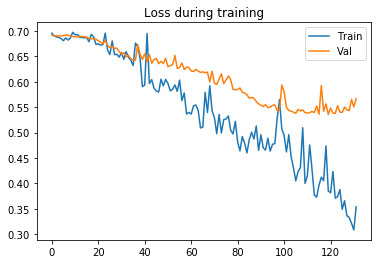

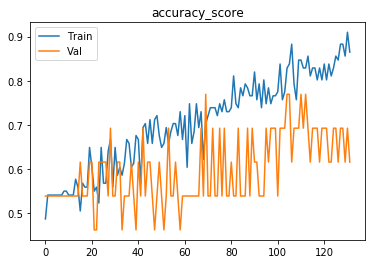

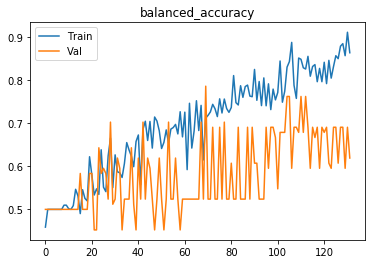

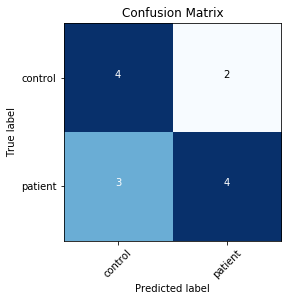

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69506
[0,    10] loss: 0.70222
[0,    15] loss: 0.70433
Time elapsed: 0h:0m:3s
train accuracy_score: 45.95 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694898
[1,     5] loss: 0.69297
[1,    10] loss: 0.69498
[1,    15] loss: 0.69218
Time elapsed: 0h:0m:6s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.83 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691341
[2,     5] loss: 0.68619
[2,    10] loss: 0.69066
[2,    15] loss: 0.68873
Time elapsed: 0h:0m:10s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690635
[3,     5] loss: 0.69122
[3,    10] loss: 0.69679
[3,    15] loss: 0.69345
Time elapsed: 0h:0m:13s
train accuracy_score: 54.05 %
train balanced_accur

Time elapsed: 0h:1m:57s
train accuracy_score: 58.56 %
train balanced_accuracy: 57.11 %
val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.662317
[34,     5] loss: 0.63189
[34,    10] loss: 0.62177
[34,    15] loss: 0.60426
Time elapsed: 0h:2m:0s
train accuracy_score: 64.86 %
train balanced_accuracy: 66.18 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.649365
[35,     5] loss: 0.70980
[35,    10] loss: 0.55305
[35,    15] loss: 0.65731
Time elapsed: 0h:2m:4s
train accuracy_score: 54.95 %
train balanced_accuracy: 53.19 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.645624
[36,     5] loss: 0.60470
[36,    10] loss: 0.59143
[36,    15] loss: 0.57176
Time elapsed: 0h:2m:7s
train accuracy_score: 68.47 %
train balanced_accuracy: 67.89 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.645306
[37,     5] loss: 0.63257
[37,    10] loss: 0.65948
[37,    15] loss: 0.55373
Time elapsed: 0h:2m:11s
train a

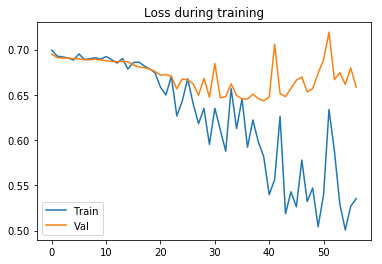

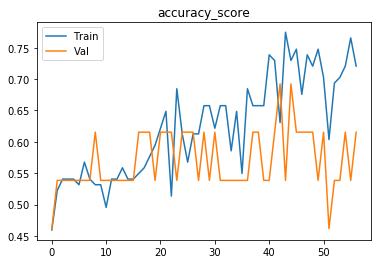

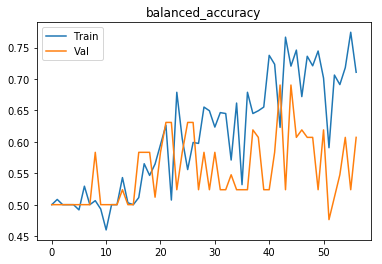

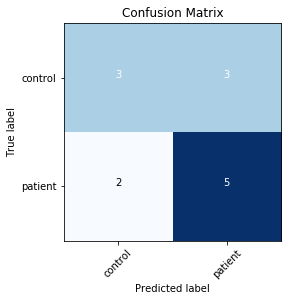

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69504
[0,    10] loss: 0.69100
[0,    15] loss: 0.69080
[0,    20] loss: 0.69925
[0,    25] loss: 0.68983
Time elapsed: 0h:0m:3s
train accuracy_score: 49.55 %
train balanced_accuracy: 46.86 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690028
[1,     5] loss: 0.68318
[1,    10] loss: 0.68079
[1,    15] loss: 0.74005
[1,    20] loss: 0.68735
[1,    25] loss: 0.67706
Time elapsed: 0h:0m:7s
train accuracy_score: 54.95 %
train balanced_accuracy: 50.98 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689862
[2,     5] loss: 0.69504
[2,    10] loss: 0.67514
[2,    15] loss: 0.70739
[2,    20] loss: 0.67406
[2,    25] loss: 0.69201
Time elapsed: 0h:0m:11s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.68950

val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.544357
[28,     5] loss: 0.40500
[28,    10] loss: 0.38873
[28,    15] loss: 0.53272
[28,    20] loss: 0.56934
[28,    25] loss: 0.42331
Time elapsed: 0h:1m:53s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.38 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.532618
[29,     5] loss: 0.44978
[29,    10] loss: 0.74616
[29,    15] loss: 0.49566
[29,    20] loss: 0.83280
[29,    25] loss: 0.53262
Time elapsed: 0h:1m:56s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.19 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.640726
[30,     5] loss: 0.54444
[30,    10] loss: 0.48359
[30,    15] loss: 0.62488
[30,    20] loss: 0.45657
[30,    25] loss: 0.57587
Time elapsed: 0h:2m:0s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.77 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.570391
[31,     5] loss: 0.33930
[31,    10] 

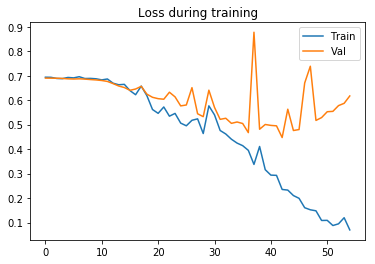

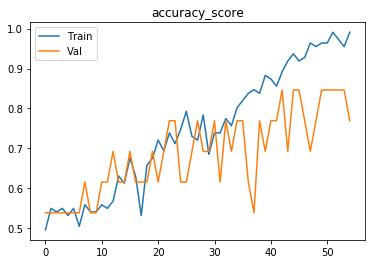

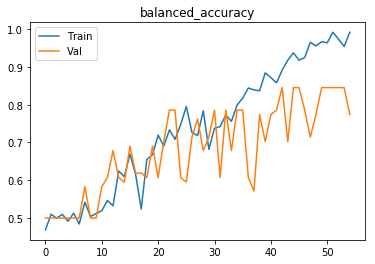

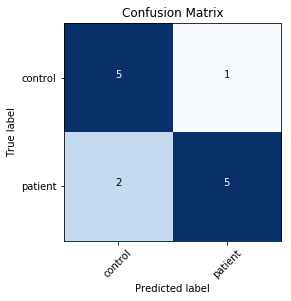

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.68292
[0,    10] loss: 0.69258
[0,    15] loss: 0.69106
[0,    20] loss: 0.68199
[0,    25] loss: 0.69908
Time elapsed: 0h:0m:2s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689907
[1,     5] loss: 0.69155
[1,    10] loss: 0.68492
[1,    15] loss: 0.68572
[1,    20] loss: 0.69784
[1,    25] loss: 0.69262
Time elapsed: 0h:0m:6s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690041
[2,     5] loss: 0.70352
[2,    10] loss: 0.70517
[2,    15] loss: 0.68855
[2,    20] loss: 0.68932
[2,    25] loss: 0.68749
Time elapsed: 0h:0m:9s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.09 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689837


val accuracy_score: 53.85 %
val balanced_accuracy: 51.19 %
Val loss: 0.615645
[28,     5] loss: 0.62971
[28,    10] loss: 0.55739
[28,    15] loss: 0.57326
[28,    20] loss: 0.52963
[28,    25] loss: 0.59870
Time elapsed: 0h:1m:33s
train accuracy_score: 68.47 %
train balanced_accuracy: 67.16 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.598913
[29,     5] loss: 0.63496
[29,    10] loss: 0.50857
[29,    15] loss: 0.51657
[29,    20] loss: 0.64170
[29,    25] loss: 0.55036
Time elapsed: 0h:1m:36s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.81 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.589100
[30,     5] loss: 0.66822
[30,    10] loss: 0.54227
[30,    15] loss: 0.45850
[30,    20] loss: 0.50797
[30,    25] loss: 0.58844
Time elapsed: 0h:1m:39s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.08 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.589070
[31,     5] loss: 0.53124
[31,    10]

val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.486051
[56,     5] loss: 0.37723
[56,    10] loss: 0.46975
[56,    15] loss: 0.43571
[56,    20] loss: 0.40269
[56,    25] loss: 0.29793
Time elapsed: 0h:3m:4s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.26 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.470429
[57,     5] loss: 0.30391
[57,    10] loss: 0.29677
[57,    15] loss: 0.51722
[57,    20] loss: 0.39300
[57,    25] loss: 0.65342
Time elapsed: 0h:3m:7s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.70 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.512783
[58,     5] loss: 0.31707
[58,    10] loss: 0.36476
[58,    15] loss: 0.53303
[58,    20] loss: 0.72389
[58,    25] loss: 0.45171
Time elapsed: 0h:3m:10s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.62 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.767387
[59,     5] loss: 0.40479
[59,    10] l

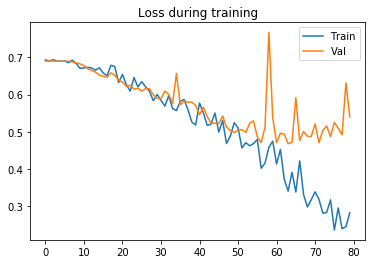

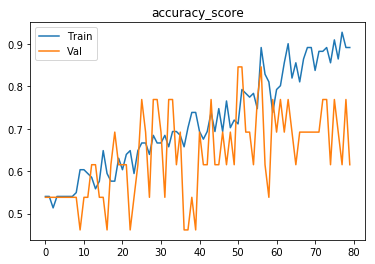

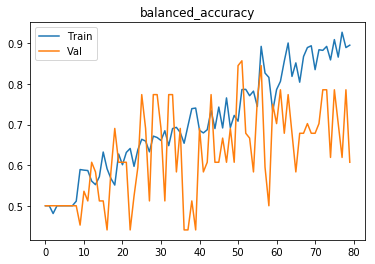

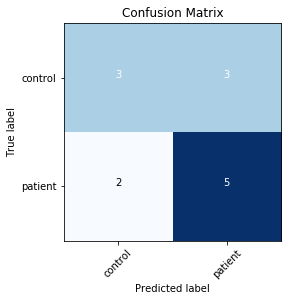

Finished outer fold.
{'final_acc': 0.7738095238095238, 'best_acc': 0.8452380952380951, 'final_iter': 55, 'best_iter': 54, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 3}
###### Starting outer fold 5
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69900
[0,    10] loss: 0.70311
[0,    15] loss: 0.69475
[0,    20] loss: 0.69672
[0,    25] loss: 0.69441
Time elapsed: 0h:0m:2s
train accuracy_score: 40.54 %
train balanced_accuracy: 40.15 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694387
[1,     5] loss: 0.69802
[1,    10] loss: 0.69997
[1,    15] loss: 0.70199
[1,    20] loss: 0.69213
[1,    25] loss: 0.69390
Time elapsed: 0h:0m:5s
train accuracy_score: 45.05 %
train balanced_accuracy: 43.87 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692477
[2,     

val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.666058
[27,     5] loss: 0.47806
[27,    10] loss: 0.57080
[27,    15] loss: 0.66327
[27,    20] loss: 0.51173
[27,    25] loss: 0.76885
Time elapsed: 0h:1m:26s
train accuracy_score: 63.96 %
train balanced_accuracy: 62.99 %
val accuracy_score: 61.54 %
val balanced_accuracy: 64.29 %
Val loss: 0.722813
[28,     5] loss: 0.70170
[28,    10] loss: 0.66545
[28,    15] loss: 0.69666
[28,    20] loss: 0.54480
[28,    25] loss: 0.59363
Time elapsed: 0h:1m:29s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.54 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.642778
[29,     5] loss: 0.64770
[29,    10] loss: 0.50452
[29,    15] loss: 0.46156
[29,    20] loss: 0.45924
[29,    25] loss: 0.58405
Time elapsed: 0h:1m:33s
train accuracy_score: 75.68 %
train balanced_accuracy: 74.71 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.631241
[30,     5] loss: 0.57983
[30,    10]

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.398085
[55,     5] loss: 0.21730
[55,    10] loss: 0.04969
[55,    15] loss: 0.07358
[55,    20] loss: 0.12827
[55,    25] loss: 0.15086
Time elapsed: 0h:2m:55s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.37 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.374111
[56,     5] loss: 0.04839
[56,    10] loss: 0.08968
[56,    15] loss: 0.34916
[56,    20] loss: 0.05658
[56,    25] loss: 0.04944
Time elapsed: 0h:2m:58s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.69 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.411671
[57,     5] loss: 0.09998
[57,    10] loss: 0.08105
[57,    15] loss: 0.07810
[57,    20] loss: 0.04155
[57,    25] loss: 0.11057
Time elapsed: 0h:3m:1s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.33 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.304887
[58,     5] loss: 0.03939
[58,    10] 

val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.089587
[83,     5] loss: 0.01979
[83,    10] loss: 0.00344
[83,    15] loss: 0.00966
[83,    20] loss: 0.02061
[83,    25] loss: 0.00231
Time elapsed: 0h:4m:23s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.151449
[84,     5] loss: 0.02066
[84,    10] loss: 0.02616
[84,    15] loss: 0.00375
[84,    20] loss: 0.00325
[84,    25] loss: 0.04981
Time elapsed: 0h:4m:26s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.02 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.095693
[85,     5] loss: 0.00335
[85,    10] loss: 0.00174
[85,    15] loss: 0.02396
[85,    20] loss: 0.01227
[85,    25] loss: 0.00106
Time elapsed: 0h:4m:29s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.285289
[86,     5] loss: 0.05225
[86

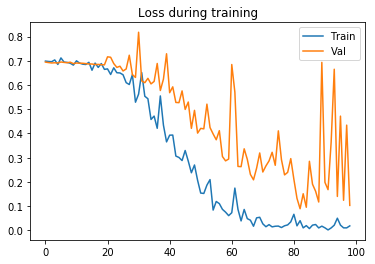

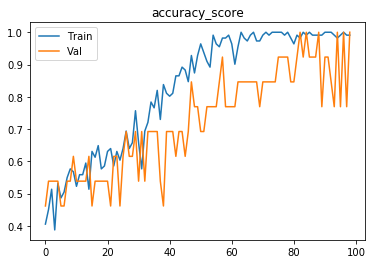

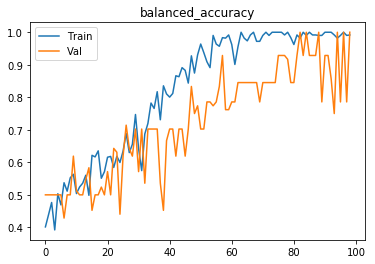

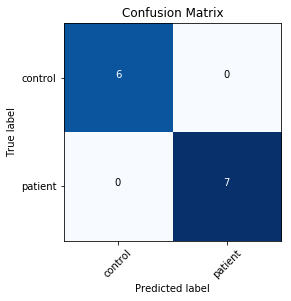

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69819
[0,    10] loss: 0.67076
[0,    15] loss: 0.70271
Time elapsed: 0h:0m:2s
train accuracy_score: 54.95 %
train balanced_accuracy: 51.13 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691126
[1,     5] loss: 0.68715
[1,    10] loss: 0.69154
[1,    15] loss: 0.69604
Time elapsed: 0h:0m:4s
train accuracy_score: 53.15 %
train balanced_accuracy: 49.17 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690838
[2,     5] loss: 0.69013
[2,    10] loss: 0.68519
[2,    15] loss: 0.69111
Time elapsed: 0h:0m:7s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691338
[3,     5] loss: 0.69016
[3,    10] loss: 0.70179
[3,    15] loss: 0.68483
Time elapsed: 0h:0m:10s
train accuracy_score: 52.25 %
train balanced_accur

Time elapsed: 0h:1m:30s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.64 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.591811
[34,     5] loss: 0.35892
[34,    10] loss: 0.34906
[34,    15] loss: 0.38179
Time elapsed: 0h:1m:32s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.16 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.503321
[35,     5] loss: 0.34394
[35,    10] loss: 0.33912
[35,    15] loss: 0.41995
Time elapsed: 0h:1m:35s
train accuracy_score: 87.39 %
train balanced_accuracy: 88.19 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.568696
[36,     5] loss: 0.44299
[36,    10] loss: 0.25410
[36,    15] loss: 0.36280
Time elapsed: 0h:1m:38s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.99 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.495724
[37,     5] loss: 0.47976
[37,    10] loss: 0.30949
[37,    15] loss: 0.46811
Time elapsed: 0h:1m:40s
trai

[67,    10] loss: 0.03384
[67,    15] loss: 0.09010
Time elapsed: 0h:3m:1s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.17 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.113689
[68,     5] loss: 0.04523
[68,    10] loss: 0.01950
[68,    15] loss: 0.04285
Time elapsed: 0h:3m:3s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.123625
[69,     5] loss: 0.05241
[69,    10] loss: 0.10137
[69,    15] loss: 0.05777
Time elapsed: 0h:3m:6s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.21 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.080688
[70,     5] loss: 0.06401
[70,    10] loss: 0.03436
[70,    15] loss: 0.02573
Time elapsed: 0h:3m:9s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.33 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.179445
[71,     5] loss: 0.09923
[71,    10] loss: 0.12815
[7

val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.183712
[101,     5] loss: 0.01409
[101,    10] loss: 0.00401
[101,    15] loss: 0.00289
Time elapsed: 0h:4m:31s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.031658
[102,     5] loss: 0.00315
[102,    10] loss: 0.00362
[102,    15] loss: 0.00404
Time elapsed: 0h:4m:34s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.134540
[103,     5] loss: 0.00840
[103,    10] loss: 0.00786
[103,    15] loss: 0.00380
Time elapsed: 0h:4m:36s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.124079
[104,     5] loss: 0.00463
[104,    10] loss: 0.00614
[104,    15] loss: 0.00034
Time elapsed: 0h:4m:39s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val ac

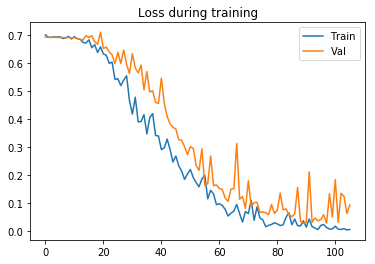

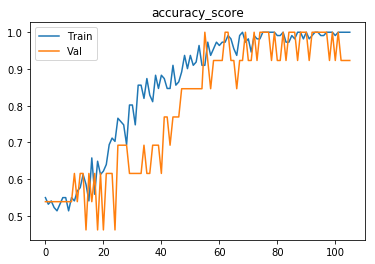

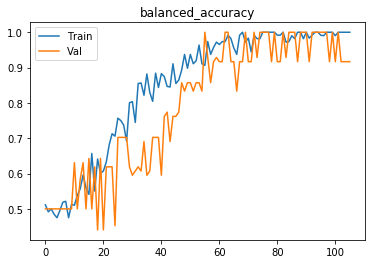

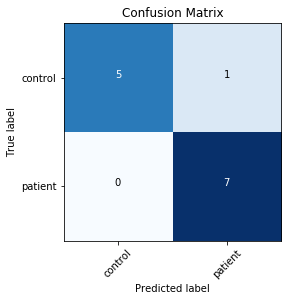

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.70073
[0,    10] loss: 0.69603
[0,    15] loss: 0.69781
Time elapsed: 0h:0m:2s
train accuracy_score: 45.95 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693962
[1,     5] loss: 0.69339
[1,    10] loss: 0.69792
[1,    15] loss: 0.70194
Time elapsed: 0h:0m:6s
train accuracy_score: 40.54 %
train balanced_accuracy: 41.32 %
val accuracy_score: 46.15 %
val balanced_accuracy: 48.81 %
Val loss: 0.693379
[2,     5] loss: 0.68951
[2,    10] loss: 0.68359
[2,    15] loss: 0.70983
Time elapsed: 0h:0m:9s
train accuracy_score: 55.86 %
train balanced_accuracy: 52.55 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690727
[3,     5] loss: 0.69099
[3,    10] loss: 0.69524
[3,    15] loss: 0.68161
Time elapsed: 0h:0m:13s
train accuracy_score: 54.05 %
train balanced_accura

Time elapsed: 0h:1m:53s
train accuracy_score: 67.57 %
train balanced_accuracy: 66.91 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.667070
[34,     5] loss: 0.59795
[34,    10] loss: 0.59822
[34,    15] loss: 0.52721
Time elapsed: 0h:1m:57s
train accuracy_score: 66.67 %
train balanced_accuracy: 65.78 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.657623
[35,     5] loss: 0.57549
[35,    10] loss: 0.50558
[35,    15] loss: 0.59501
Time elapsed: 0h:2m:0s
train accuracy_score: 69.37 %
train balanced_accuracy: 70.49 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.639897
[36,     5] loss: 0.54437
[36,    10] loss: 0.54844
[36,    15] loss: 0.68868
Time elapsed: 0h:2m:3s
train accuracy_score: 67.57 %
train balanced_accuracy: 66.32 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.656394
[37,     5] loss: 0.51498
[37,    10] loss: 0.62793
[37,    15] loss: 0.46922
Time elapsed: 0h:2m:7s
train a

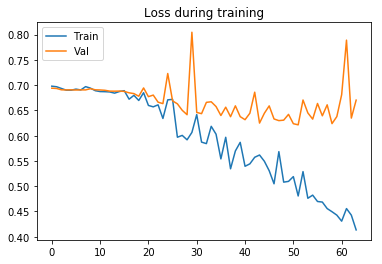

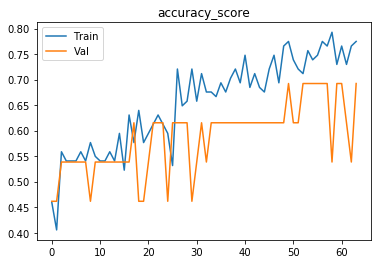

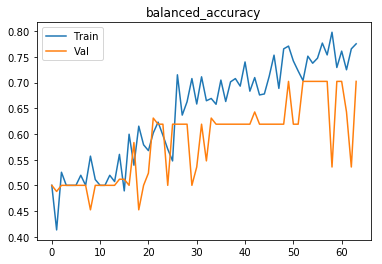

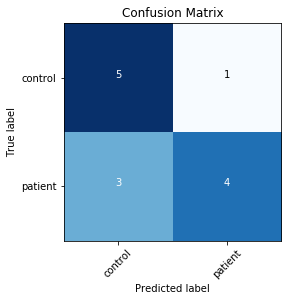

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69207
[0,    10] loss: 0.69928
[0,    15] loss: 0.69271
[0,    20] loss: 0.69399
[0,    25] loss: 0.70654
Time elapsed: 0h:0m:3s
train accuracy_score: 46.85 %
train balanced_accuracy: 47.01 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691092
[1,     5] loss: 0.68352
[1,    10] loss: 0.68248
[1,    15] loss: 0.71881
[1,    20] loss: 0.68581
[1,    25] loss: 0.68462
Time elapsed: 0h:0m:7s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691930
[2,     5] loss: 0.68157
[2,    10] loss: 0.67742
[2,    15] loss: 0.72697
[2,    20] loss: 0.68858
[2,    25] loss: 0.70014
Time elapsed: 0h:0m:11s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691118

val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.661827
[28,     5] loss: 0.62291
[28,    10] loss: 0.60658
[28,    15] loss: 0.59514
[28,    20] loss: 0.56352
[28,    25] loss: 0.64281
Time elapsed: 0h:1m:49s
train accuracy_score: 62.16 %
train balanced_accuracy: 61.32 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.661453
[29,     5] loss: 0.64176
[29,    10] loss: 0.59378
[29,    15] loss: 0.67461
[29,    20] loss: 0.56263
[29,    25] loss: 0.49805
Time elapsed: 0h:1m:53s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.96 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.652076
[30,     5] loss: 0.50330
[30,    10] loss: 0.78290
[30,    15] loss: 0.60304
[30,    20] loss: 0.63582
[30,    25] loss: 0.68419
Time elapsed: 0h:1m:57s
train accuracy_score: 60.36 %
train balanced_accuracy: 59.95 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.687421
[31,     5] loss: 0.72455
[31,    10]

val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.897115
[56,     5] loss: 0.79106
[56,    10] loss: 0.44948
[56,    15] loss: 0.57829
[56,    20] loss: 0.53231
[56,    25] loss: 0.38582
Time elapsed: 0h:3m:36s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.27 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.673425
[57,     5] loss: 0.38987
[57,    10] loss: 0.33540
[57,    15] loss: 0.41623
[57,    20] loss: 0.47782
[57,    25] loss: 0.37121
Time elapsed: 0h:3m:40s
train accuracy_score: 81.08 %
train balanced_accuracy: 80.59 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.700750
[58,     5] loss: 0.41265
[58,    10] loss: 0.35303
[58,    15] loss: 0.48962
[58,    20] loss: 0.29993
[58,    25] loss: 0.40055
Time elapsed: 0h:3m:44s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.53 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.710994
[59,     5] loss: 0.39003
[59,    10]

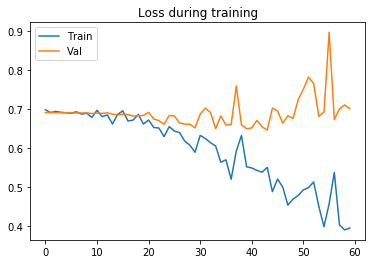

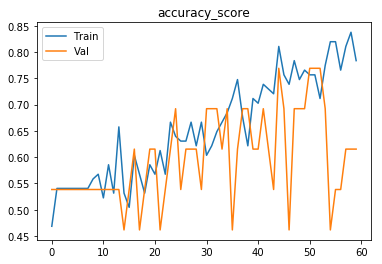

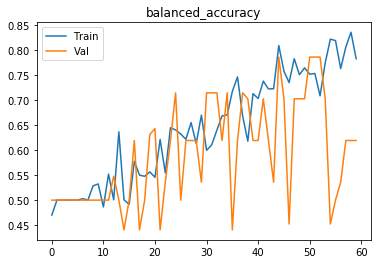

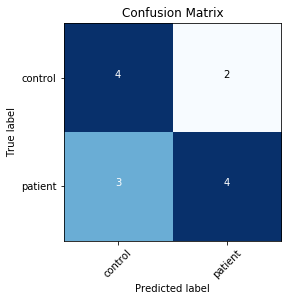

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69450
[0,    10] loss: 0.69323
[0,    15] loss: 0.70596
Time elapsed: 0h:0m:2s
train accuracy_score: 52.25 %
train balanced_accuracy: 55.39 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691285
[1,     5] loss: 0.68138
[1,    10] loss: 0.72812
[1,    15] loss: 0.68839
Time elapsed: 0h:0m:6s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691916
[2,     5] loss: 0.69224
[2,    10] loss: 0.69388
[2,    15] loss: 0.69324
Time elapsed: 0h:0m:9s
train accuracy_score: 54.05 %
train balanced_accuracy: 53.68 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692361
[3,     5] loss: 0.68717
[3,    10] loss: 0.69375
[3,    15] loss: 0.69924
Time elapsed: 0h:0m:13s
train accuracy_score: 54.95 %
train balanced_accur

Time elapsed: 0h:1m:54s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.05 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.635705
[34,     5] loss: 0.42767
[34,    10] loss: 0.52890
[34,    15] loss: 0.40486
Time elapsed: 0h:1m:57s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.53 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.671752
[35,     5] loss: 0.35723
[35,    10] loss: 0.29576
[35,    15] loss: 0.39526
Time elapsed: 0h:2m:0s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.07 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.612334
[36,     5] loss: 0.40682
[36,    10] loss: 0.36917
[36,    15] loss: 0.34584
Time elapsed: 0h:2m:4s
train accuracy_score: 82.88 %
train balanced_accuracy: 83.28 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.610600
[37,     5] loss: 0.35236
[37,    10] loss: 0.27551
[37,    15] loss: 0.42974
Time elapsed: 0h:2m:7s
train a

Best result during training: 0.79. Saving model..
Finished inner fold.


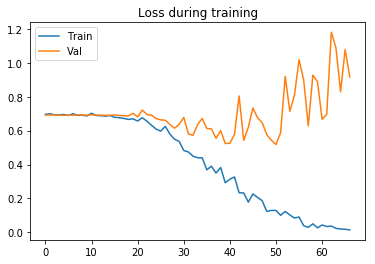

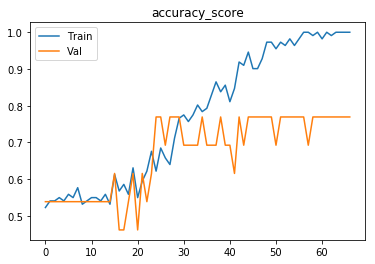

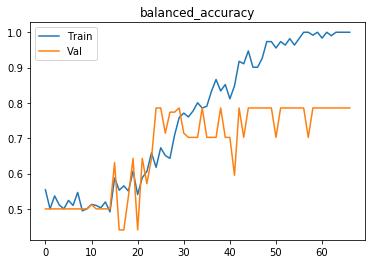

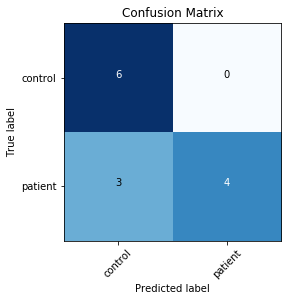

Finished outer fold.
{'final_acc': 1.0, 'best_acc': 1.0, 'final_iter': 99, 'best_iter': 99, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 6
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69416
[0,    10] loss: 0.70024
[0,    15] loss: 0.69384
Time elapsed: 0h:0m:2s
train accuracy_score: 39.64 %
train balanced_accuracy: 39.72 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.696712
[1,     5] loss: 0.68889
[1,    10] loss: 0.69321
[1,    15] loss: 0.69216
Time elapsed: 0h:0m:5s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.24 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.726647
[2,     5] loss: 0.69637
[2,    10] loss: 0.69336
[2,    15] loss: 0.69692
Time elapsed: 0h:0m:7s
train accuracy_score: 45.05 %
train balan

Time elapsed: 0h:1m:28s
train accuracy_score: 63.06 %
train balanced_accuracy: 63.27 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.27 %
Val loss: 0.689784
[33,     5] loss: 0.63814
[33,    10] loss: 0.71339
[33,    15] loss: 0.57651
Time elapsed: 0h:1m:31s
train accuracy_score: 61.26 %
train balanced_accuracy: 60.65 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.27 %
Val loss: 0.672671
[34,     5] loss: 0.57433
[34,    10] loss: 0.63338
[34,    15] loss: 0.59438
Time elapsed: 0h:1m:33s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.36 %
val accuracy_score: 53.85 %
val balanced_accuracy: 72.73 %
Val loss: 0.747030
[35,     5] loss: 0.56597
[35,    10] loss: 0.53473
[35,    15] loss: 0.53630
Time elapsed: 0h:1m:36s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.27 %
val accuracy_score: 46.15 %
val balanced_accuracy: 47.73 %
Val loss: 0.756497
[36,     5] loss: 0.58206
[36,    10] loss: 0.59285
[36,    15] loss: 0.66154
Time elapsed: 0h:1m:39s
trai

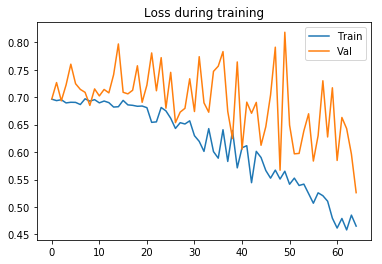

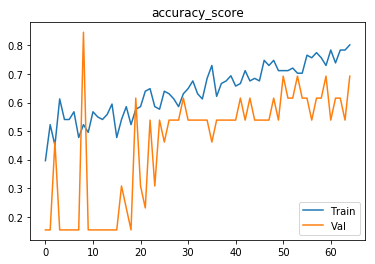

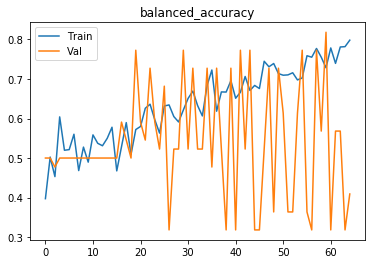

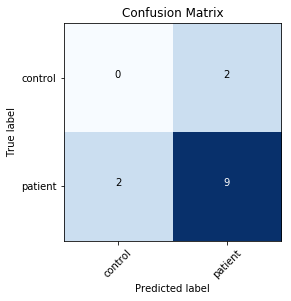

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69650
Time elapsed: 0h:0m:1s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.718851
[1,     5] loss: 0.68454
Time elapsed: 0h:0m:4s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.729978
[2,     5] loss: 0.69185
Time elapsed: 0h:0m:6s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.721914
[3,     5] loss: 0.69420
Time elapsed: 0h:0m:8s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.717547
[4,     5] loss: 0.68995
Time elapsed: 0h:0m:10s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 

val accuracy_score: 53.85 %
val balanced_accuracy: 72.73 %
Val loss: 0.875936
[43,     5] loss: 0.57685
Time elapsed: 0h:1m:40s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.00 %
val accuracy_score: 38.46 %
val balanced_accuracy: 22.73 %
Val loss: 0.744673
[44,     5] loss: 0.54402
Time elapsed: 0h:1m:42s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.23 %
val accuracy_score: 38.46 %
val balanced_accuracy: 63.64 %
Val loss: 0.997730
[45,     5] loss: 0.61198
Time elapsed: 0h:1m:44s
train accuracy_score: 67.57 %
train balanced_accuracy: 66.61 %
val accuracy_score: 53.85 %
val balanced_accuracy: 72.73 %
Val loss: 0.814748
[46,     5] loss: 0.60363
Time elapsed: 0h:1m:46s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.72 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.671422
[47,     5] loss: 0.53111
Time elapsed: 0h:1m:48s
train accuracy_score: 71.17 %
train balanced_accuracy: 70.71 %
val accuracy_score: 53.85 %
val balanced_accu

val accuracy_score: 61.54 %
val balanced_accuracy: 56.82 %
Val loss: 0.726372
[86,     5] loss: 0.51062
Time elapsed: 0h:3m:17s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.42 %
val accuracy_score: 61.54 %
val balanced_accuracy: 77.27 %
Val loss: 0.803653
[87,     5] loss: 0.47360
Time elapsed: 0h:3m:20s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.12 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.645964
[88,     5] loss: 0.42798
Time elapsed: 0h:3m:22s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.30 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.697864
[89,     5] loss: 0.47754
Time elapsed: 0h:3m:24s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.28 %
val accuracy_score: 61.54 %
val balanced_accuracy: 56.82 %
Val loss: 0.706291
Early stopping in epoch 90
Total time elapsed: 0h:3m:25s
Writing model to disk...
Best result during training: 0.77. Saving model..
Finished inner fold.


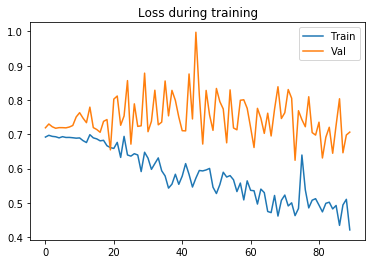

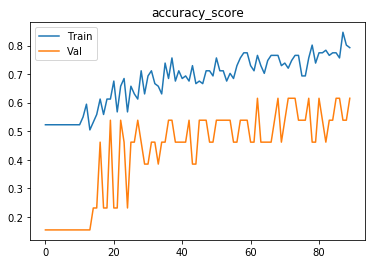

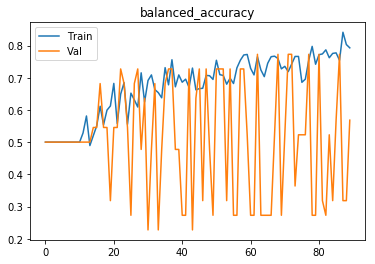

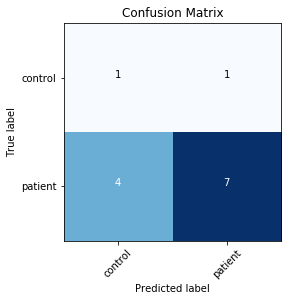

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69401
Time elapsed: 0h:0m:2s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.90 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.722660
[1,     5] loss: 0.69524
Time elapsed: 0h:0m:5s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.725524
[2,     5] loss: 0.69550
Time elapsed: 0h:0m:8s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.30 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.728172
[3,     5] loss: 0.68831
Time elapsed: 0h:0m:11s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.94 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.749642
[4,     5] loss: 0.70354
Time elapsed: 0h:0m:14s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.4

val accuracy_score: 69.23 %
val balanced_accuracy: 81.82 %
Val loss: 0.707482
[43,     5] loss: 0.49602
Time elapsed: 0h:2m:11s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.77 %
val accuracy_score: 61.54 %
val balanced_accuracy: 36.36 %
Val loss: 0.544927
[44,     5] loss: 0.50048
Time elapsed: 0h:2m:13s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.67 %
val accuracy_score: 69.23 %
val balanced_accuracy: 81.82 %
Val loss: 0.703447
[45,     5] loss: 0.53963
Time elapsed: 0h:2m:16s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.59 %
val accuracy_score: 69.23 %
val balanced_accuracy: 81.82 %
Val loss: 0.779895
[46,     5] loss: 0.50404
Time elapsed: 0h:2m:20s
train accuracy_score: 79.28 %
train balanced_accuracy: 78.55 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.568654
[47,     5] loss: 0.51892
Time elapsed: 0h:2m:22s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.19 %
val accuracy_score: 61.54 %
val balanced_accu

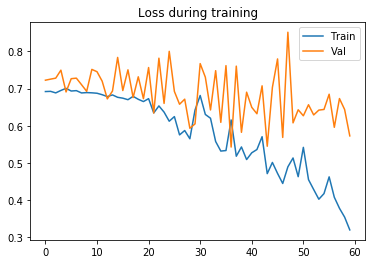

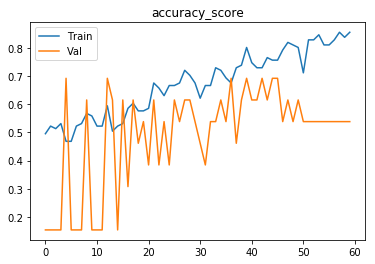

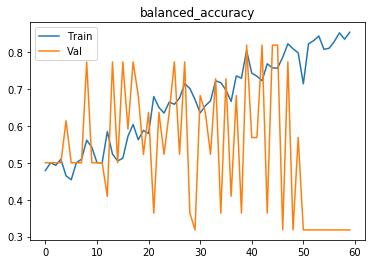

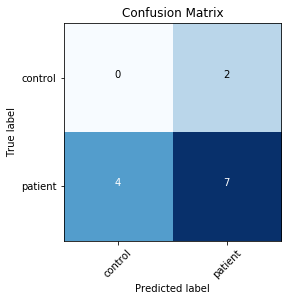

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69207
[0,    10] loss: 0.69670
[0,    15] loss: 0.70809
Time elapsed: 0h:0m:2s
train accuracy_score: 48.65 %
train balanced_accuracy: 50.86 %
val accuracy_score: 84.62 %
val balanced_accuracy: 50.00 %
Val loss: 0.686054
[1,     5] loss: 0.69214
[1,    10] loss: 0.69233
[1,    15] loss: 0.69041
Time elapsed: 0h:0m:6s
train accuracy_score: 45.05 %
train balanced_accuracy: 43.84 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.715076
[2,     5] loss: 0.69096
[2,    10] loss: 0.69261
[2,    15] loss: 0.69298
Time elapsed: 0h:0m:9s
train accuracy_score: 49.55 %
train balanced_accuracy: 48.15 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.698429
[3,     5] loss: 0.69203
[3,    10] loss: 0.68444
[3,    15] loss: 0.69646
Time elapsed: 0h:0m:13s
train accuracy_score: 51.35 %
train balanced_accura

Time elapsed: 0h:1m:54s
train accuracy_score: 62.16 %
train balanced_accuracy: 61.52 %
val accuracy_score: 53.85 %
val balanced_accuracy: 72.73 %
Val loss: 0.750209
[34,     5] loss: 0.57766
[34,    10] loss: 0.53091
[34,    15] loss: 0.53688
Time elapsed: 0h:1m:58s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.11 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.602604
[35,     5] loss: 0.57589
[35,    10] loss: 0.54576
[35,    15] loss: 0.52945
Time elapsed: 0h:2m:1s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.14 %
val accuracy_score: 46.15 %
val balanced_accuracy: 27.27 %
Val loss: 0.626959
[36,     5] loss: 0.66695
[36,    10] loss: 0.64031
[36,    15] loss: 0.57838
Time elapsed: 0h:2m:4s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.26 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.619425
[37,     5] loss: 0.61711
[37,    10] loss: 0.55488
[37,    15] loss: 0.67513
Time elapsed: 0h:2m:8s
train a

[67,    10] loss: 0.35954
[67,    15] loss: 0.51030
Time elapsed: 0h:3m:49s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.33 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.601200
[68,     5] loss: 0.44121
[68,    10] loss: 0.47195
[68,    15] loss: 0.47233
Time elapsed: 0h:3m:52s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.62 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.559478
[69,     5] loss: 0.46969
[69,    10] loss: 0.41904
[69,    15] loss: 0.42211
Time elapsed: 0h:3m:56s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.08 %
val accuracy_score: 61.54 %
val balanced_accuracy: 56.82 %
Val loss: 0.779540
[70,     5] loss: 0.43543
[70,    10] loss: 0.40672
[70,    15] loss: 0.35345
Time elapsed: 0h:3m:59s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.51 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.626772
Early stopping in epoch 71
Total time elapsed: 0h:3m:5

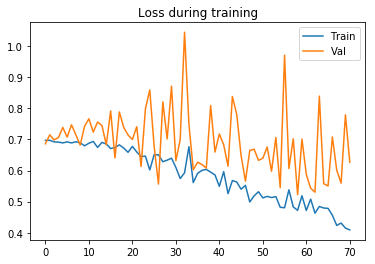

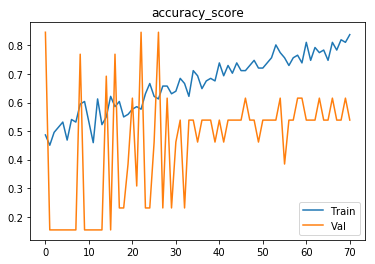

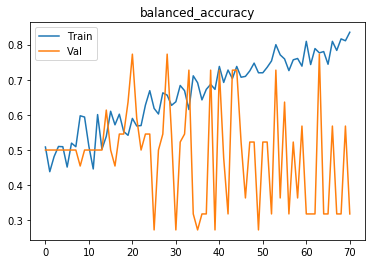

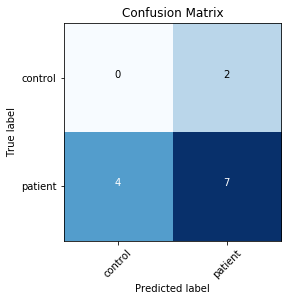

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.70028
[0,    10] loss: 0.69223
[0,    15] loss: 0.67626
Time elapsed: 0h:0m:2s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.14 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.768489
[1,     5] loss: 0.68254
[1,    10] loss: 0.68727
[1,    15] loss: 0.68908
Time elapsed: 0h:0m:4s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.733449
[2,     5] loss: 0.69605
[2,    10] loss: 0.69785
[2,    15] loss: 0.69003
Time elapsed: 0h:0m:7s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.58 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.708120
[3,     5] loss: 0.69439
[3,    10] loss: 0.69644
[3,    15] loss: 0.68685
Time elapsed: 0h:0m:10s
train accuracy_score: 52.25 %
train balanced_accur

Time elapsed: 0h:1m:30s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.64 %
val accuracy_score: 76.92 %
val balanced_accuracy: 86.36 %
Val loss: 0.502461
[34,     5] loss: 0.49577
[34,    10] loss: 0.26495
[34,    15] loss: 0.49671
Time elapsed: 0h:1m:32s
train accuracy_score: 81.08 %
train balanced_accuracy: 80.92 %
val accuracy_score: 84.62 %
val balanced_accuracy: 90.91 %
Val loss: 0.359372
[35,     5] loss: 0.27164
[35,    10] loss: 0.39971
[35,    15] loss: 0.23574
Time elapsed: 0h:1m:35s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.26 %
val accuracy_score: 84.62 %
val balanced_accuracy: 70.45 %
Val loss: 0.243872
[36,     5] loss: 0.54306
[36,    10] loss: 0.18162
[36,    15] loss: 0.45765
Time elapsed: 0h:1m:38s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.31 %
val accuracy_score: 92.31 %
val balanced_accuracy: 95.45 %
Val loss: 0.254501
[37,     5] loss: 0.37524
[37,    10] loss: 0.37449
[37,    15] loss: 0.30773
Time elapsed: 0h:1m:40s
trai

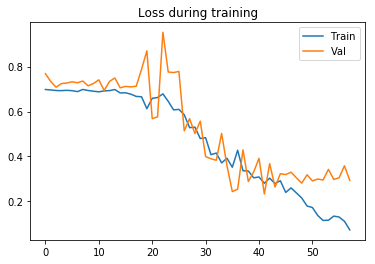

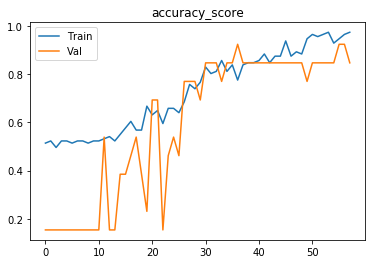

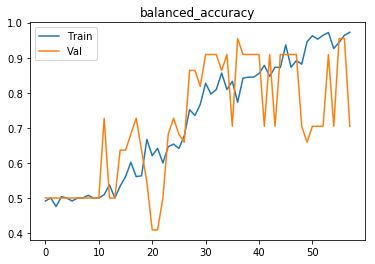

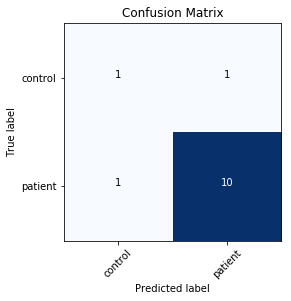

Finished outer fold.
{'final_acc': 0.7045454545454546, 'best_acc': 0.9545454545454546, 'final_iter': 58, 'best_iter': 57, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}
###### Starting outer fold 7
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69143
Time elapsed: 0h:0m:1s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697594
[1,     5] loss: 0.69190
Time elapsed: 0h:0m:4s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696872
[2,     5] loss: 0.69175
Time elapsed: 0h:0m:6s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697139
[3,     5] loss: 0.

[41,     5] loss: 0.59854
Time elapsed: 0h:1m:34s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.11 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.594743
[42,     5] loss: 0.64287
Time elapsed: 0h:1m:37s
train accuracy_score: 61.26 %
train balanced_accuracy: 61.39 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.591683
[43,     5] loss: 0.59205
Time elapsed: 0h:1m:39s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.66 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.589786
[44,     5] loss: 0.61693
Time elapsed: 0h:1m:41s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.16 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.605114
[45,     5] loss: 0.66445
Time elapsed: 0h:1m:43s
train accuracy_score: 59.46 %
train balanced_accuracy: 59.17 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.602125
[46,     5] loss: 0.62908
Time elapsed: 0h:1m

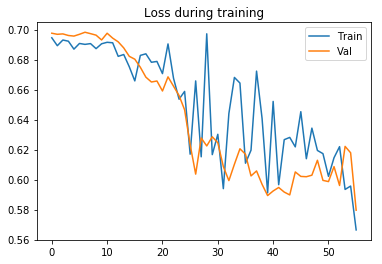

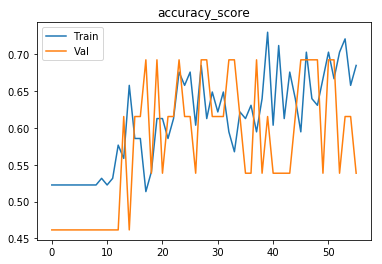

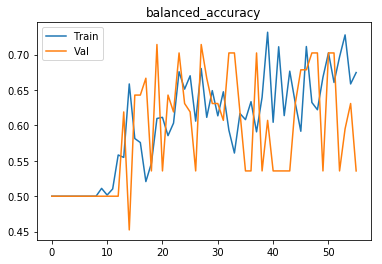

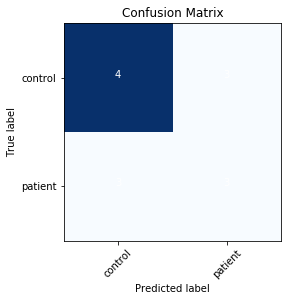

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69922
[0,    10] loss: 0.69619
[0,    15] loss: 0.69321
[0,    20] loss: 0.69703
[0,    25] loss: 0.69095
Time elapsed: 0h:0m:2s
train accuracy_score: 45.05 %
train balanced_accuracy: 45.06 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.692202
[1,     5] loss: 0.69506
[1,    10] loss: 0.69163
[1,    15] loss: 0.69463
[1,    20] loss: 0.69461
[1,    25] loss: 0.69418
Time elapsed: 0h:0m:5s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.80 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.691950
[2,     5] loss: 0.69247
[2,    10] loss: 0.69372
[2,    15] loss: 0.69080
[2,    20] loss: 0.69715
[2,    25] loss: 0.68645
Time elapsed: 0h:0m:9s
train accuracy_score: 54.95 %
train balanced_accuracy: 53.64 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692151


val accuracy_score: 46.15 %
val balanced_accuracy: 47.62 %
Val loss: 0.668244
[28,     5] loss: 0.64918
[28,    10] loss: 0.62993
[28,    15] loss: 0.65907
[28,    20] loss: 0.61080
[28,    25] loss: 0.60805
Time elapsed: 0h:1m:31s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.50 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.666140
[29,     5] loss: 0.62038
[29,    10] loss: 0.67752
[29,    15] loss: 0.56122
[29,    20] loss: 0.71118
[29,    25] loss: 0.72292
Time elapsed: 0h:1m:34s
train accuracy_score: 63.06 %
train balanced_accuracy: 62.95 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.648722
[30,     5] loss: 0.55873
[30,    10] loss: 0.59807
[30,    15] loss: 0.60008
[30,    20] loss: 0.79305
[30,    25] loss: 0.67573
Time elapsed: 0h:1m:37s
train accuracy_score: 63.96 %
train balanced_accuracy: 64.22 %
val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.661905
[31,     5] loss: 0.68647
[31,    10]

val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.629547
[56,     5] loss: 0.55118
[56,    10] loss: 0.53580
[56,    15] loss: 0.59462
[56,    20] loss: 0.50642
[56,    25] loss: 0.50348
Time elapsed: 0h:2m:59s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.59 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.645343
[57,     5] loss: 0.48489
[57,    10] loss: 0.51380
[57,    15] loss: 0.42312
[57,    20] loss: 0.37688
[57,    25] loss: 0.64577
Time elapsed: 0h:3m:2s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.90 %
val accuracy_score: 53.85 %
val balanced_accuracy: 55.95 %
Val loss: 0.663302
[58,     5] loss: 0.52269
[58,    10] loss: 0.44154
[58,    15] loss: 0.59000
[58,    20] loss: 0.58397
[58,    25] loss: 0.48948
Time elapsed: 0h:3m:5s
train accuracy_score: 72.07 %
train balanced_accuracy: 71.73 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.628453
[59,     5] loss: 0.47902
[59,    10] l

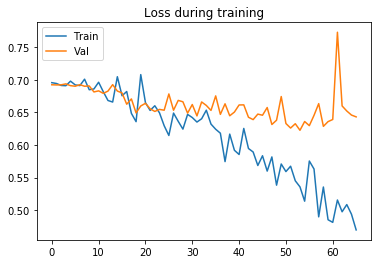

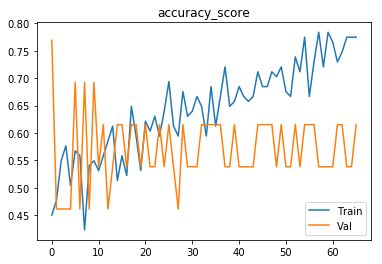

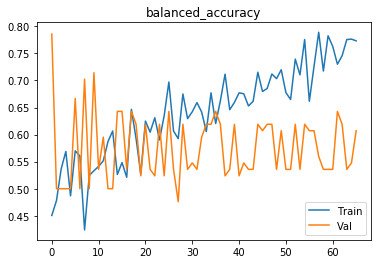

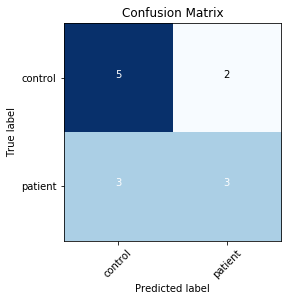

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69925
[0,    10] loss: 0.70090
[0,    15] loss: 0.68343
[0,    20] loss: 0.69500
[0,    25] loss: 0.68574
Time elapsed: 0h:0m:3s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698450
[1,     5] loss: 0.68641
[1,    10] loss: 0.69389
[1,    15] loss: 0.69384
[1,    20] loss: 0.68814
[1,    25] loss: 0.69912
Time elapsed: 0h:0m:7s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697782
[2,     5] loss: 0.68644
[2,    10] loss: 0.69018
[2,    15] loss: 0.68908
[2,    20] loss: 0.70017
[2,    25] loss: 0.70818
Time elapsed: 0h:0m:11s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696510

val accuracy_score: 53.85 %
val balanced_accuracy: 57.14 %
Val loss: 0.663468
[28,     5] loss: 0.61269
[28,    10] loss: 0.69115
[28,    15] loss: 0.70302
[28,    20] loss: 0.64991
[28,    25] loss: 0.64385
Time elapsed: 0h:1m:49s
train accuracy_score: 59.46 %
train balanced_accuracy: 59.34 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.637438
[29,     5] loss: 0.62034
[29,    10] loss: 0.61291
[29,    15] loss: 0.65267
[29,    20] loss: 0.61290
[29,    25] loss: 0.58882
Time elapsed: 0h:1m:53s
train accuracy_score: 70.27 %
train balanced_accuracy: 69.93 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.637604
[30,     5] loss: 0.58661
[30,    10] loss: 0.56471
[30,    15] loss: 0.67072
[30,    20] loss: 0.57938
[30,    25] loss: 0.73555
Time elapsed: 0h:1m:57s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.59 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.597703
[31,     5] loss: 0.68699
[31,    10]

val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.616359
[56,     5] loss: 0.35625
[56,    10] loss: 0.50067
[56,    15] loss: 0.34032
[56,    20] loss: 0.51287
[56,    25] loss: 0.37971
Time elapsed: 0h:3m:36s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.52 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.606408
Early stopping in epoch 57
Total time elapsed: 0h:3m:36s
Writing model to disk...
Best result during training: 0.71. Saving model..
Finished inner fold.


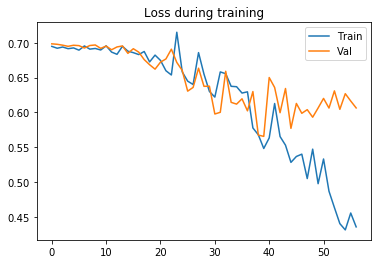

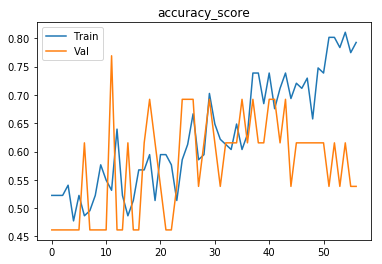

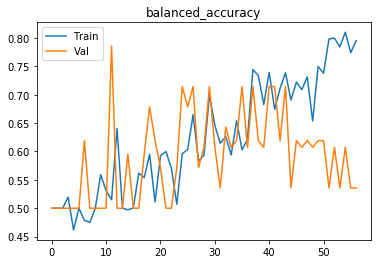

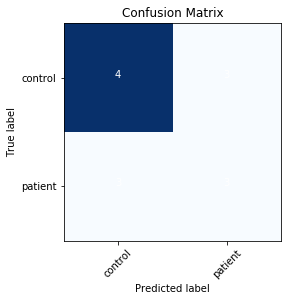

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.70146
[0,    10] loss: 0.69329
[0,    15] loss: 0.69156
[0,    20] loss: 0.68620
[0,    25] loss: 0.68704
Time elapsed: 0h:0m:3s
train accuracy_score: 50.45 %
train balanced_accuracy: 52.34 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694916
[1,     5] loss: 0.68166
[1,    10] loss: 0.78781
[1,    15] loss: 0.70833
[1,    20] loss: 0.69245
[1,    25] loss: 0.69941
Time elapsed: 0h:0m:7s
train accuracy_score: 44.14 %
train balanced_accuracy: 43.62 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691095
[2,     5] loss: 0.69362
[2,    10] loss: 0.69204
[2,    15] loss: 0.69519
[2,    20] loss: 0.69526
[2,    25] loss: 0.68524
Time elapsed: 0h:0m:11s
train accuracy_score: 52.25 %
train balanced_accuracy: 52.36 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.69530

val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.642751
[28,     5] loss: 0.61475
[28,    10] loss: 0.59979
[28,    15] loss: 0.54670
[28,    20] loss: 0.55213
[28,    25] loss: 0.73450
Time elapsed: 0h:1m:50s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.11 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.654029
[29,     5] loss: 0.50170
[29,    10] loss: 0.57711
[29,    15] loss: 0.61618
[29,    20] loss: 0.56303
[29,    25] loss: 0.53056
Time elapsed: 0h:1m:53s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.40 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.689057
[30,     5] loss: 0.56858
[30,    10] loss: 0.58685
[30,    15] loss: 0.66532
[30,    20] loss: 0.49213
[30,    25] loss: 0.74170
Time elapsed: 0h:1m:57s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.80 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.663538
[31,     5] loss: 0.60148
[31,    10]

val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 1.297024
[56,     5] loss: 0.06219
[56,    10] loss: 0.02956
[56,    15] loss: 0.06027
[56,    20] loss: 0.04270
[56,    25] loss: 0.12074
Time elapsed: 0h:3m:36s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.06 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 1.603515
[57,     5] loss: 0.06914
[57,    10] loss: 0.04377
[57,    15] loss: 0.03103
[57,    20] loss: 0.03728
[57,    25] loss: 0.02635
Time elapsed: 0h:3m:40s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.14 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 1.485251
Early stopping in epoch 58
Total time elapsed: 0h:3m:40s
Writing model to disk...
Best result during training: 0.75. Saving model..
Finished inner fold.


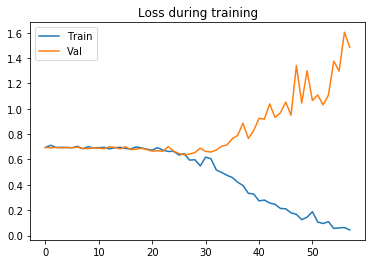

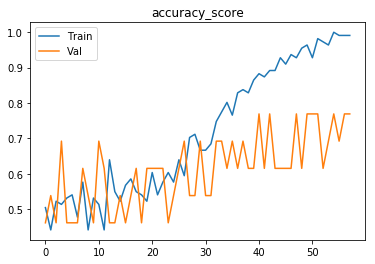

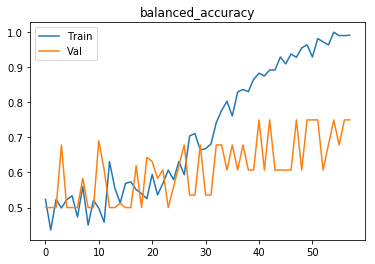

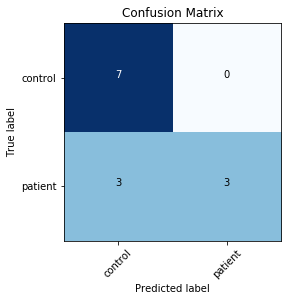

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69220
[0,    10] loss: 0.70284
[0,    15] loss: 0.68756
[0,    20] loss: 0.69665
[0,    25] loss: 0.69436
Time elapsed: 0h:0m:2s
train accuracy_score: 51.35 %
train balanced_accuracy: 53.37 %
val accuracy_score: 53.85 %
val balanced_accuracy: 51.19 %
Val loss: 0.692191
[1,     5] loss: 0.69044
[1,    10] loss: 0.69300
[1,    15] loss: 0.70319
[1,    20] loss: 0.68844
[1,    25] loss: 0.68779
Time elapsed: 0h:0m:5s
train accuracy_score: 48.65 %
train balanced_accuracy: 47.45 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695381
[2,     5] loss: 0.69369
[2,    10] loss: 0.69462
[2,    15] loss: 0.69349
[2,    20] loss: 0.69854
[2,    25] loss: 0.69438
Time elapsed: 0h:0m:8s
train accuracy_score: 50.45 %
train balanced_accuracy: 48.93 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694207


val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.680334
[28,     5] loss: 0.68283
[28,    10] loss: 0.66757
[28,    15] loss: 0.68804
[28,    20] loss: 0.67244
[28,    25] loss: 0.64770
Time elapsed: 0h:1m:30s
train accuracy_score: 59.46 %
train balanced_accuracy: 59.50 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.689992
[29,     5] loss: 0.65359
[29,    10] loss: 0.66516
[29,    15] loss: 0.69054
[29,    20] loss: 0.65554
[29,    25] loss: 0.69895
Time elapsed: 0h:1m:34s
train accuracy_score: 53.15 %
train balanced_accuracy: 52.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.683142
[30,     5] loss: 0.69674
[30,    10] loss: 0.71626
[30,    15] loss: 0.68207
[30,    20] loss: 0.70208
[30,    25] loss: 0.67501
Time elapsed: 0h:1m:37s
train accuracy_score: 52.25 %
train balanced_accuracy: 51.63 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.686212
[31,     5] loss: 0.66236
[31,    10]

val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.549503
[56,     5] loss: 0.28613
[56,    10] loss: 0.42154
[56,    15] loss: 0.22316
[56,    20] loss: 0.30181
[56,    25] loss: 0.30259
Time elapsed: 0h:2m:58s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.58 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.534434
[57,     5] loss: 0.30182
[57,    10] loss: 0.41481
[57,    15] loss: 0.34033
[57,    20] loss: 0.19459
[57,    25] loss: 0.44708
Time elapsed: 0h:3m:1s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.99 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.469565
[58,     5] loss: 0.48910
[58,    10] loss: 0.32516
[58,    15] loss: 0.27678
[58,    20] loss: 0.38431
[58,    25] loss: 0.15946
Time elapsed: 0h:3m:5s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.22 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.538071
[59,     5] loss: 0.24767
[59,    10] l

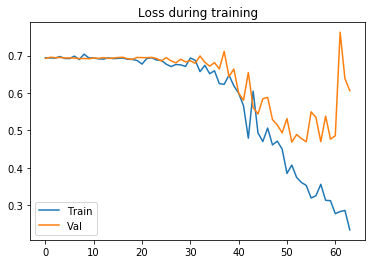

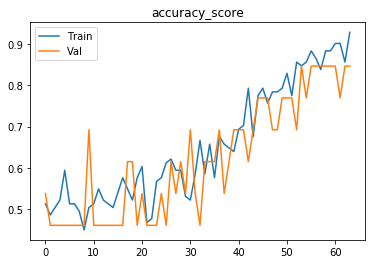

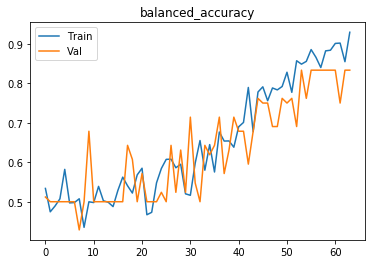

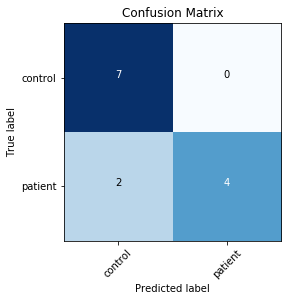

Finished outer fold.
{'final_acc': 0.8333333333333333, 'best_acc': 0.8333333333333333, 'final_iter': 64, 'best_iter': 64, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}
###### Starting outer fold 8
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69632
Time elapsed: 0h:0m:1s
train accuracy_score: 45.05 %
train balanced_accuracy: 45.37 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693653
[1,     5] loss: 0.69409
Time elapsed: 0h:0m:4s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.44 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694948
[2,     5] loss: 0.69295
Time elapsed: 0h:0m:6s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694091
[3,     5] loss: 0.

[41,     5] loss: 0.45057
Time elapsed: 0h:1m:36s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.62 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.528386
[42,     5] loss: 0.45064
Time elapsed: 0h:1m:38s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.68 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.481012
[43,     5] loss: 0.52224
Time elapsed: 0h:1m:41s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.09 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.489551
[44,     5] loss: 0.46958
Time elapsed: 0h:1m:43s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.87 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.504939
[45,     5] loss: 0.55670
Time elapsed: 0h:1m:46s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.05 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.536820
[46,     5] loss: 0.61579
Time elapsed: 0h:1m

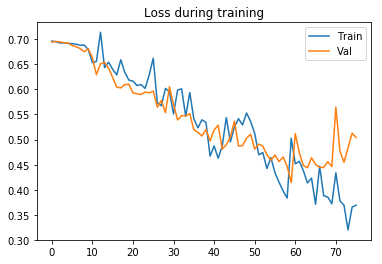

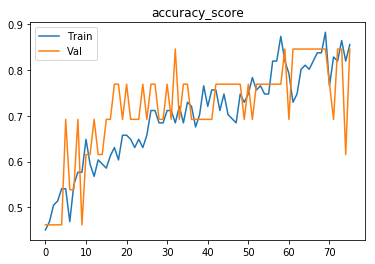

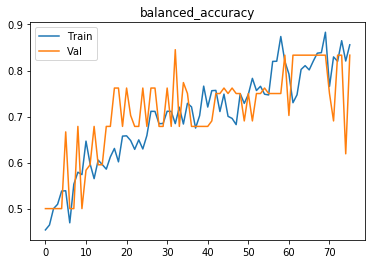

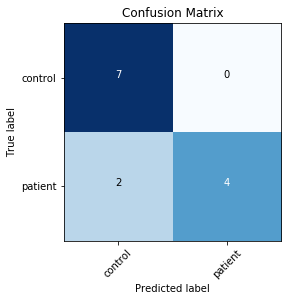

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69542
Time elapsed: 0h:0m:1s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.34 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695692
[1,     5] loss: 0.69376
Time elapsed: 0h:0m:4s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.05 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693155
[2,     5] loss: 0.69517
Time elapsed: 0h:0m:6s
train accuracy_score: 40.54 %
train balanced_accuracy: 40.76 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692426
[3,     5] loss: 0.69247
Time elapsed: 0h:0m:8s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.89 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692455
[4,     5] loss: 0.69227
Time elapsed: 0h:0m:11s
train accuracy_score: 54.95 %
train balanced_accuracy: 55.06 

val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.580419
[43,     5] loss: 0.58504
Time elapsed: 0h:1m:42s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.25 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.570070
[44,     5] loss: 0.55518
Time elapsed: 0h:1m:44s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.56 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.570201
[45,     5] loss: 0.58176
Time elapsed: 0h:1m:46s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.19 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.527161
[46,     5] loss: 0.51546
Time elapsed: 0h:1m:49s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.26 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.521086
[47,     5] loss: 0.57580
Time elapsed: 0h:1m:51s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.02 %
val accuracy_score: 69.23 %
val balanced_accu

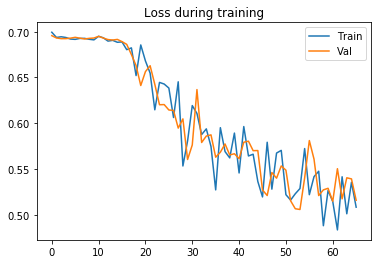

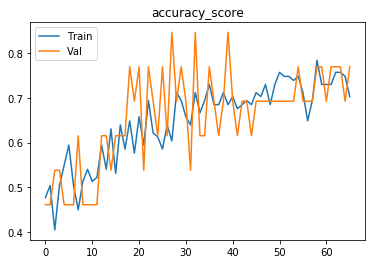

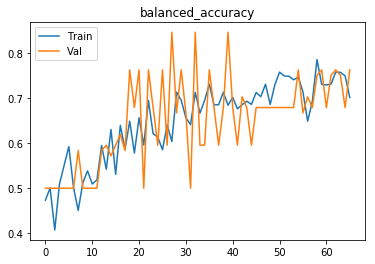

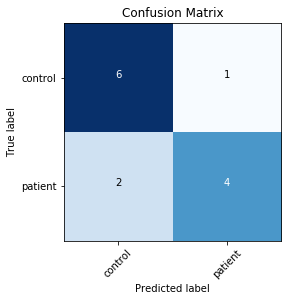

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69563
[0,    10] loss: 0.70924
[0,    15] loss: 0.69168
[0,    20] loss: 0.69043
[0,    25] loss: 0.69346
Time elapsed: 0h:0m:3s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.86 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692799
[1,     5] loss: 0.69879
[1,    10] loss: 0.69020
[1,    15] loss: 0.69359
[1,    20] loss: 0.69072
[1,    25] loss: 0.68997
Time elapsed: 0h:0m:7s
train accuracy_score: 48.65 %
train balanced_accuracy: 48.81 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692985
[2,     5] loss: 0.69480
[2,    10] loss: 0.69139
[2,    15] loss: 0.69104
[2,    20] loss: 0.69982
[2,    25] loss: 0.68904
Time elapsed: 0h:0m:11s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.78 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.693263

val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.651175
[28,     5] loss: 0.51108
[28,    10] loss: 0.61942
[28,    15] loss: 0.82555
[28,    20] loss: 0.64163
[28,    25] loss: 0.60593
Time elapsed: 0h:1m:51s
train accuracy_score: 63.96 %
train balanced_accuracy: 64.16 %
val accuracy_score: 46.15 %
val balanced_accuracy: 48.81 %
Val loss: 0.678218
[29,     5] loss: 0.72251
[29,    10] loss: 0.63732
[29,    15] loss: 0.55955
[29,    20] loss: 0.55581
[29,    25] loss: 0.55633
Time elapsed: 0h:1m:55s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.93 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.647278
[30,     5] loss: 0.63652
[30,    10] loss: 0.50273
[30,    15] loss: 0.59568
[30,    20] loss: 0.63818
[30,    25] loss: 0.60055
Time elapsed: 0h:1m:59s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.53 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.623851
[31,     5] loss: 0.47281
[31,    10]

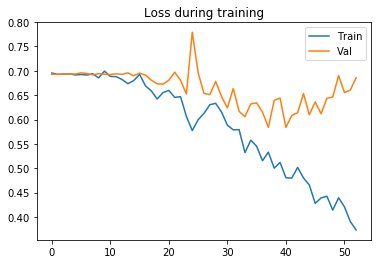

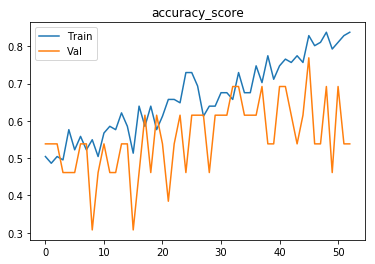

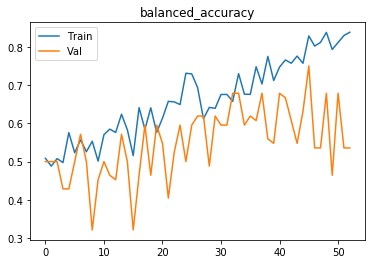

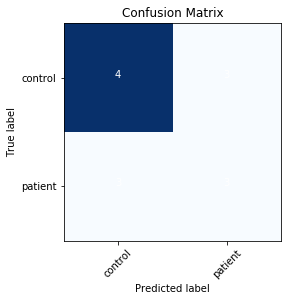

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69514
[0,    10] loss: 0.69504
[0,    15] loss: 0.68973
Time elapsed: 0h:0m:2s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695791
[1,     5] loss: 0.69409
[1,    10] loss: 0.69007
[1,    15] loss: 0.69656
Time elapsed: 0h:0m:6s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695597
[2,     5] loss: 0.69667
[2,    10] loss: 0.69134
[2,    15] loss: 0.68792
Time elapsed: 0h:0m:9s
train accuracy_score: 53.15 %
train balanced_accuracy: 52.78 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694501
[3,     5] loss: 0.69449
[3,    10] loss: 0.69215
[3,    15] loss: 0.70550
Time elapsed: 0h:0m:13s
train accuracy_score: 45.05 %
train balanced_accura

Time elapsed: 0h:1m:55s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.31 %
val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.636407
[34,     5] loss: 0.53578
[34,    10] loss: 0.57563
[34,    15] loss: 0.58177
Time elapsed: 0h:1m:59s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.47 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.616651
[35,     5] loss: 0.57184
[35,    10] loss: 0.59699
[35,    15] loss: 0.57895
Time elapsed: 0h:2m:2s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.94 %
val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.636495
[36,     5] loss: 0.59241
[36,    10] loss: 0.58391
[36,    15] loss: 0.50874
Time elapsed: 0h:2m:5s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.61 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.612720
[37,     5] loss: 0.57930
[37,    10] loss: 0.60000
[37,    15] loss: 0.54017
Time elapsed: 0h:2m:9s
train a

[67,    10] loss: 0.44325
[67,    15] loss: 0.34377
Time elapsed: 0h:3m:51s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.27 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.601620
[68,     5] loss: 0.35237
[68,    10] loss: 0.36638
[68,    15] loss: 0.48767
Time elapsed: 0h:3m:54s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.03 %
val accuracy_score: 46.15 %
val balanced_accuracy: 48.81 %
Val loss: 0.752609
Early stopping in epoch 69
Total time elapsed: 0h:3m:55s
Writing model to disk...
Best result during training: 0.75. Saving model..
Finished inner fold.


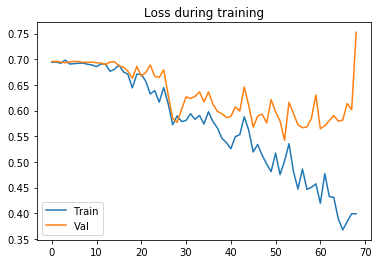

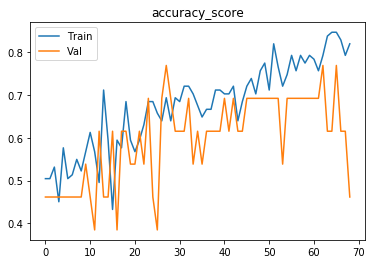

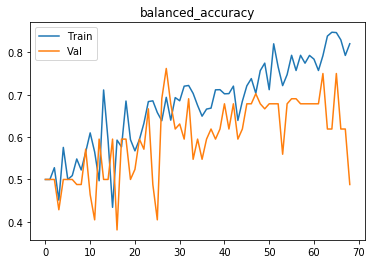

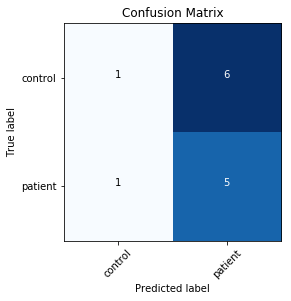

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69476
[0,    10] loss: 0.69128
[0,    15] loss: 0.69245
[0,    20] loss: 0.69810
[0,    25] loss: 0.68703
Time elapsed: 0h:0m:3s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.70 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692250
[1,     5] loss: 0.69183
[1,    10] loss: 0.69354
[1,    15] loss: 0.68635
[1,    20] loss: 0.70819
[1,    25] loss: 0.69001
Time elapsed: 0h:0m:7s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.19 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694903
[2,     5] loss: 0.69591
[2,    10] loss: 0.69378
[2,    15] loss: 0.69339
[2,    20] loss: 0.70100
[2,    25] loss: 0.69569
Time elapsed: 0h:0m:11s
train accuracy_score: 41.44 %
train balanced_accuracy: 41.64 %
val accuracy_score: 53.85 %
val balanced_accuracy: 57.14 %
Val loss: 0.693428

val accuracy_score: 30.77 %
val balanced_accuracy: 30.95 %
Val loss: 0.718170
[28,     5] loss: 0.56271
[28,    10] loss: 0.53125
[28,    15] loss: 0.68862
[28,    20] loss: 0.54717
[28,    25] loss: 0.70041
Time elapsed: 0h:1m:51s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.72 %
val accuracy_score: 38.46 %
val balanced_accuracy: 39.29 %
Val loss: 0.722908
[29,     5] loss: 0.58111
[29,    10] loss: 0.75473
[29,    15] loss: 0.53265
[29,    20] loss: 0.54317
[29,    25] loss: 0.51947
Time elapsed: 0h:1m:55s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.91 %
val accuracy_score: 46.15 %
val balanced_accuracy: 45.24 %
Val loss: 0.706295
[30,     5] loss: 0.55741
[30,    10] loss: 0.46711
[30,    15] loss: 0.61575
[30,    20] loss: 0.57745
[30,    25] loss: 0.60625
Time elapsed: 0h:1m:59s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.17 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.671500
[31,     5] loss: 0.61208
[31,    10]

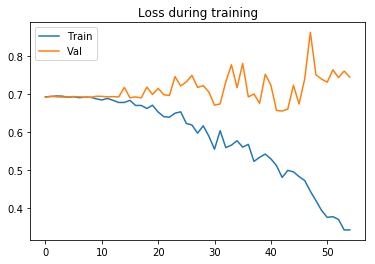

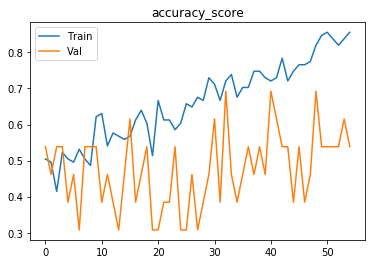

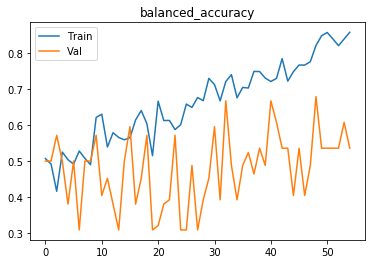

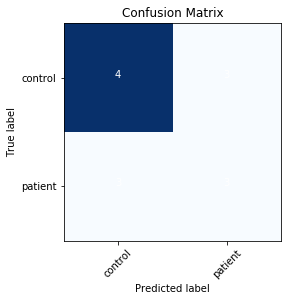

Finished outer fold.
{'final_acc': 0.8333333333333333, 'best_acc': 0.8333333333333333, 'final_iter': 76, 'best_iter': 33, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 9
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69310
Time elapsed: 0h:0m:1s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694481
[1,     5] loss: 0.69260
Time elapsed: 0h:0m:4s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.16 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694604
[2,     5] loss: 0.68908
Time elapsed: 0h:0m:6s
train accuracy_score: 57.66 %
train balanced_accuracy: 56.80 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690037
[3,     5] loss: 

[41,     5] loss: 0.50746
Time elapsed: 0h:1m:37s
train accuracy_score: 74.77 %
train balanced_accuracy: 75.37 %
val accuracy_score: 53.85 %
val balanced_accuracy: 55.95 %
Val loss: 0.702903
[42,     5] loss: 0.55722
Time elapsed: 0h:1m:40s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.19 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.653215
[43,     5] loss: 0.56125
Time elapsed: 0h:1m:42s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.38 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.655073
[44,     5] loss: 0.45399
Time elapsed: 0h:1m:44s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.56 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.652315
[45,     5] loss: 0.49413
Time elapsed: 0h:1m:47s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.55 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.642988
[46,     5] loss: 0.49375
Time elapsed: 0h:1m

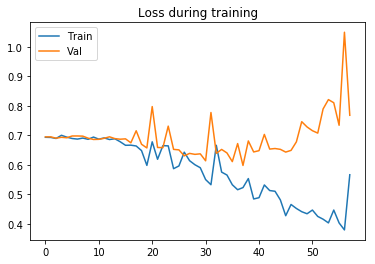

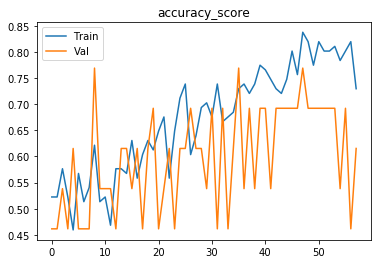

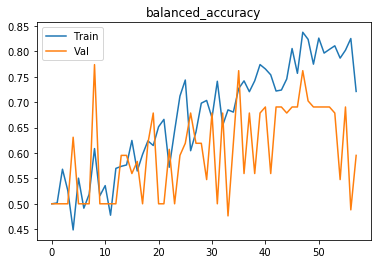

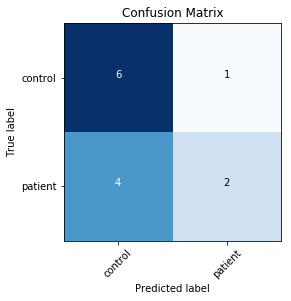

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 428545
[0,     5] loss: 0.69571
Time elapsed: 0h:0m:1s
train accuracy_score: 40.54 %
train balanced_accuracy: 39.20 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693528
[1,     5] loss: 0.69285
Time elapsed: 0h:0m:4s
train accuracy_score: 56.76 %
train balanced_accuracy: 55.86 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694457
[2,     5] loss: 0.69146
Time elapsed: 0h:0m:6s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695266
[3,     5] loss: 0.69096
Time elapsed: 0h:0m:8s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.21 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694884
[4,     5] loss: 0.68970
Time elapsed: 0h:0m:11s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.33 

val accuracy_score: 53.85 %
val balanced_accuracy: 57.14 %
Val loss: 0.691871
[43,     5] loss: 0.58986
Time elapsed: 0h:1m:42s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.56 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.621478
[44,     5] loss: 0.52089
Time elapsed: 0h:1m:44s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.16 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.672184
[45,     5] loss: 0.68553
Time elapsed: 0h:1m:46s
train accuracy_score: 59.46 %
train balanced_accuracy: 58.93 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.624389
[46,     5] loss: 0.58510
Time elapsed: 0h:1m:49s
train accuracy_score: 69.37 %
train balanced_accuracy: 70.53 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.623453
[47,     5] loss: 0.53256
Time elapsed: 0h:1m:51s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.23 %
val accuracy_score: 53.85 %
val balanced_accu

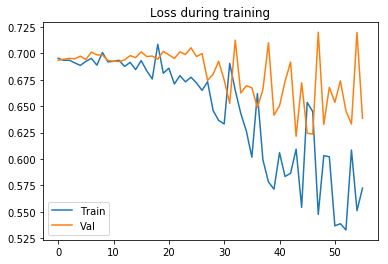

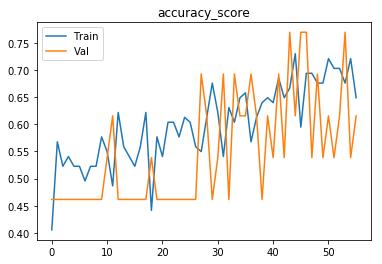

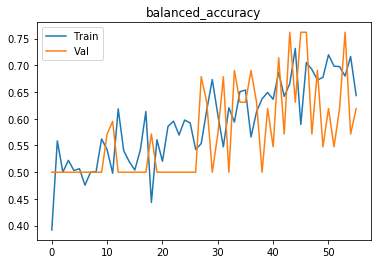

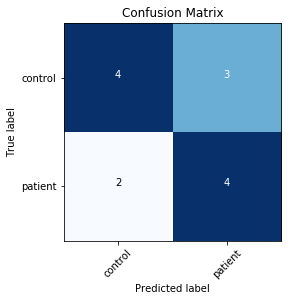

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 471329
[0,     5] loss: 0.69473
Time elapsed: 0h:0m:2s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696029
[1,     5] loss: 0.69319
Time elapsed: 0h:0m:5s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.59 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691580
[2,     5] loss: 0.69013
Time elapsed: 0h:0m:8s
train accuracy_score: 58.56 %
train balanced_accuracy: 58.47 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693088
[3,     5] loss: 0.69060
Time elapsed: 0h:0m:11s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.42 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.691636
[4,     5] loss: 0.69635
Time elapsed: 0h:0m:14s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.9

val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.652355
[43,     5] loss: 0.39371
Time elapsed: 0h:2m:13s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.03 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.649151
[44,     5] loss: 0.40521
Time elapsed: 0h:2m:16s
train accuracy_score: 83.78 %
train balanced_accuracy: 84.16 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.718074
[45,     5] loss: 0.46126
Time elapsed: 0h:2m:19s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.05 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.752644
[46,     5] loss: 0.48892
Time elapsed: 0h:2m:22s
train accuracy_score: 69.37 %
train balanced_accuracy: 70.12 %
val accuracy_score: 46.15 %
val balanced_accuracy: 48.81 %
Val loss: 0.838137
[47,     5] loss: 0.41203
Time elapsed: 0h:2m:25s
train accuracy_score: 80.18 %
train balanced_accuracy: 79.90 %
val accuracy_score: 69.23 %
val balanced_accu

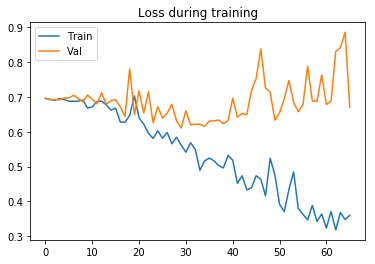

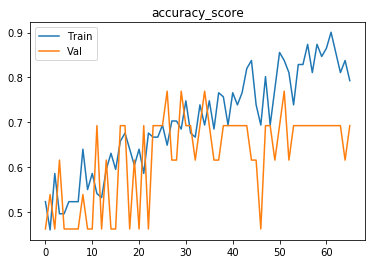

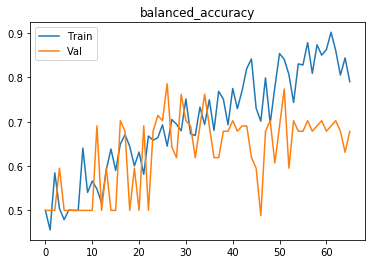

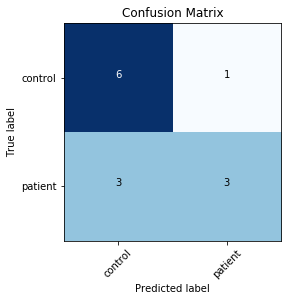

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 471329
[0,     5] loss: 0.69410
Time elapsed: 0h:0m:2s
train accuracy_score: 47.75 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691661
[1,     5] loss: 0.69262
Time elapsed: 0h:0m:5s
train accuracy_score: 47.75 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692399
[2,     5] loss: 0.69690
Time elapsed: 0h:0m:8s
train accuracy_score: 42.34 %
train balanced_accuracy: 43.12 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694621
[3,     5] loss: 0.69023
Time elapsed: 0h:0m:11s
train accuracy_score: 54.95 %
train balanced_accuracy: 53.32 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696216
[4,     5] loss: 0.68439
Time elapsed: 0h:0m:14s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.22

val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.597392
[43,     5] loss: 0.59219
Time elapsed: 0h:2m:13s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.83 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.660589
[44,     5] loss: 0.57601
Time elapsed: 0h:2m:16s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.48 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.598822
[45,     5] loss: 0.53482
Time elapsed: 0h:2m:19s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.61 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.603955
[46,     5] loss: 0.56017
Time elapsed: 0h:2m:22s
train accuracy_score: 64.86 %
train balanced_accuracy: 65.40 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.606854
[47,     5] loss: 0.56412
Time elapsed: 0h:2m:25s
train accuracy_score: 70.27 %
train balanced_accuracy: 69.76 %
val accuracy_score: 69.23 %
val balanced_accu

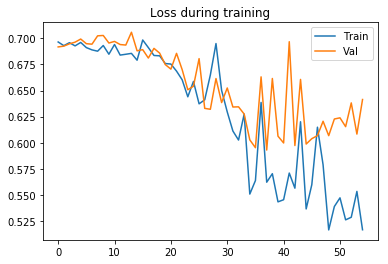

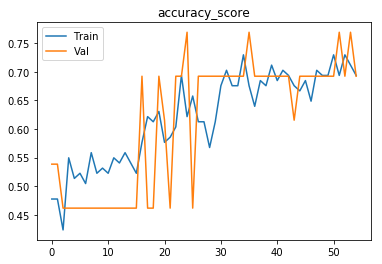

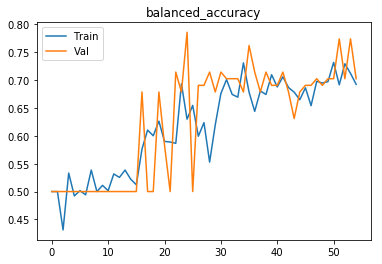

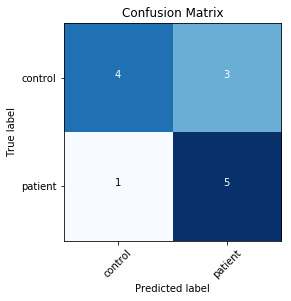

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 428545
[0,     5] loss: 0.69601
Time elapsed: 0h:0m:1s
train accuracy_score: 46.85 %
train balanced_accuracy: 48.08 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694879
[1,     5] loss: 0.69595
Time elapsed: 0h:0m:4s
train accuracy_score: 45.05 %
train balanced_accuracy: 44.89 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693347
[2,     5] loss: 0.69049
Time elapsed: 0h:0m:6s
train accuracy_score: 56.76 %
train balanced_accuracy: 55.94 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697681
[3,     5] loss: 0.69034
Time elapsed: 0h:0m:9s
train accuracy_score: 48.65 %
train balanced_accuracy: 47.69 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695013
[4,     5] loss: 0.69612
Time elapsed: 0h:0m:11s
train accuracy_score: 54.05 %
train balanced_accuracy: 54.08

val accuracy_score: 53.85 %
val balanced_accuracy: 57.14 %
Val loss: 0.715651
[43,     5] loss: 0.59526
Time elapsed: 0h:1m:43s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.609675
[44,     5] loss: 0.54126
Time elapsed: 0h:1m:46s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.85 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.614101
[45,     5] loss: 0.50809
Time elapsed: 0h:1m:48s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.83 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.609392
[46,     5] loss: 0.52943
Time elapsed: 0h:1m:51s
train accuracy_score: 70.27 %
train balanced_accuracy: 69.60 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.613713
[47,     5] loss: 0.49577
Time elapsed: 0h:1m:53s
train accuracy_score: 73.87 %
train balanced_accuracy: 74.76 %
val accuracy_score: 69.23 %
val balanced_accu

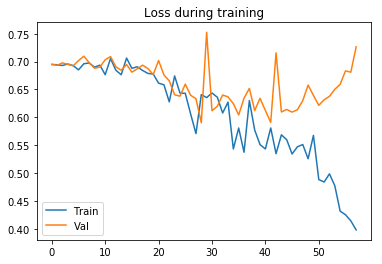

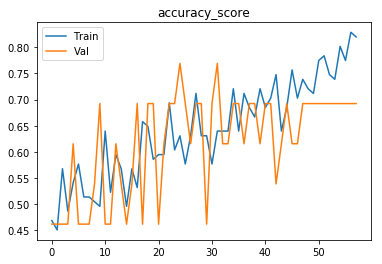

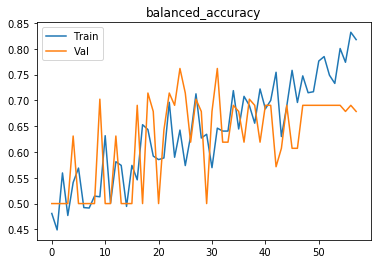

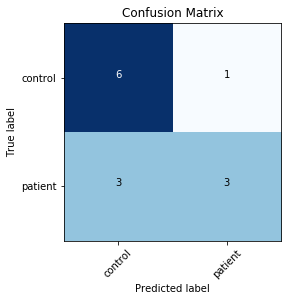

Finished outer fold.
{'final_acc': 0.7023809523809523, 'best_acc': 0.7738095238095238, 'final_iter': 55, 'best_iter': 25, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}
################################
################################
All accuracies: [0.761904761904762, 0.5952380952380952, 0.75, 0.8333333333333333, 0.6904761904761905, 0.7750000000000001, 0.8125, 0.875, 0.8125, 0.7750000000000001, 0.75, 0.9285714285714286, 0.8333333333333333, 0.8333333333333333, 0.7142857142857143, 0.9166666666666667, 0.8452380952380951, 0.8452380952380951, 0.7738095238095238, 0.8452380952380951, 0.7142857142857143, 0.6190476190476191, 0.6071428571428572, 0.7738095238095238, 0.6071428571428572, 1.0, 0.9166666666666667, 0.7023809523809523, 0.6190476190476191, 0.7857142857142857, 0.4090909090909091, 0.5681818181818181, 0.31818181818181823, 0.31818181818181823, 0.7045454545454546, 0.5357142857142857, 0.6071428571428572, 0.5357142857142857, 0.75, 0.8333

In [20]:
fold_metric, models = run(net=None, data=[X, y],
                  k_folds=-1,
                  callbacks=None,
                  augmentations=augmentations,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [21]:
5/0

ZeroDivisionError: division by zero

In [6]:
training_res = [{'final_acc': 0.761904761904762, 'best_acc': 0.8571428571428572, 'final_iter': 55, 'best_iter': 53, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0},
                {'final_acc': 0.875, 'best_acc': 0.875, 'final_iter': 63, 'best_iter': 63, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2},
                {'final_acc': 0.9285714285714286, 'best_acc': 0.9285714285714286, 'final_iter': 78, 'best_iter': 78, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1},
                {'final_acc': 0.9166666666666667, 'best_acc': 0.9166666666666667, 'final_iter': 79, 'best_iter': 79, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 0},
                {'final_acc': 0.7738095238095238, 'best_acc': 0.8452380952380951, 'final_iter': 55, 'best_iter': 54, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 3},
                {'final_acc': 1.0, 'best_acc': 1.0, 'final_iter': 99, 'best_iter': 99, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0},
                {'final_acc': 0.7045454545454546, 'best_acc': 0.9545454545454546, 'final_iter': 58, 'best_iter': 57, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4},
                {'final_acc': 0.8333333333333333, 'best_acc': 0.8333333333333333, 'final_iter': 64, 'best_iter': 64, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4},
                {'final_acc': 0.8333333333333333, 'best_acc': 0.8333333333333333, 'final_iter': 76, 'best_iter': 33, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0},
                {'final_acc': 0.7023809523809523, 'best_acc': 0.7738095238095238, 'final_iter': 55, 'best_iter': 25, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}
               ]

In [ ]:
"""training_res = [{'final_acc': 0.761904761904762, 'best_acc': 0.9166666666666667, 'final_iter': 63, 'best_iter': 52, 'params': {'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4},
 {'final_acc': 0.875, 'best_acc': 0.875, 'final_iter': 86, 'best_iter': 86, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 4},
 {'final_acc': 1.0, 'best_acc': 1.0, 'final_iter': 93, 'best_iter': 93, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4},
 {'final_acc': 0.9285714285714286, 'best_acc': 1.0, 'final_iter': 94, 'best_iter': 62, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 0},
 {'final_acc': 0.8571428571428572, 'best_acc': 0.9285714285714286, 'final_iter': 139, 'best_iter': 116, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1},
 {'final_acc': 0.7857142857142857, 'best_acc': 0.7857142857142857, 'final_iter': 63, 'best_iter': 63, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4},
 {'final_acc': 0.9090909090909093, 'best_acc': 0.9545454545454546, 'final_iter': 62, 'best_iter': 52, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0},
 {'final_acc': 0.761904761904762, 'best_acc': 0.8452380952380951, 'final_iter': 54, 'best_iter': 37, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4},
 {'final_acc': 0.6785714285714286, 'best_acc': 0.6785714285714286, 'final_iter': 53, 'best_iter': 36, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4},
 {'final_acc': 0.8452380952380951, 'best_acc': 0.8452380952380951, 'final_iter': 56, 'best_iter': 56, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 3}
]"""

In [ ]:
"""training_res = [{'final_acc': 0.75, 'best_acc': 0.9166666666666667, 'final_iter': 84, 'best_iter': 10, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1},
{'final_acc': 0.875, 'best_acc': 0.875, 'final_iter': 60, 'best_iter': 0, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 3},
{'final_acc': 0.8452380952380951, 'best_acc': 0.9166666666666667, 'final_iter': 200, 'best_iter': 159, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 1e-05}, 'inner_fold_idx': 1},
{'final_acc': 0.9166666666666667, 'best_acc': 1.0, 'final_iter': 55, 'best_iter': 20, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1},
{'final_acc': 0.6190476190476191, 'best_acc': 0.7023809523809523, 'final_iter': 186, 'best_iter': 2, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 1e-05}, 'inner_fold_idx': 1},
{'final_acc': 0.7142857142857143, 'best_acc': 0.7142857142857143, 'final_iter': 59, 'best_iter': 0, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2},
{'final_acc': 0.7045454545454546, 'best_acc': 0.9090909090909093, 'final_iter': 65, 'best_iter': 5, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1},
{'final_acc': 0.761904761904762, 'best_acc': 0.8333333333333333, 'final_iter': 63, 'best_iter': 3, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1},
{'final_acc': 0.761904761904762, 'best_acc': 0.8452380952380951, 'final_iter': 182, 'best_iter': 95, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 1e-05}, 'inner_fold_idx': 4},
{'final_acc': 0.6785714285714286, 'best_acc': 0.761904761904762, 'final_iter': 43, 'best_iter': 26, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2}]"""

In [23]:
print(len(training_res))

10


In [ ]:
"""training_res = [{'final_acc': 0.761904761904762, 'best_acc': 0.8452380952380951, 'final_iter': 100, 'best_iter': 16, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0},
{'final_acc': 0.875, 'best_acc': 0.875, 'final_iter': 47, 'best_iter': 0, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3},
{'final_acc': 1.0, 'best_acc': 1.0, 'final_iter': 84, 'best_iter': 0, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1},
{'final_acc': 0.9285714285714286, 'best_acc': 1.0, 'final_iter': 128, 'best_iter': 69, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4},
{'final_acc': 0.7023809523809523, 'best_acc': 0.8333333333333333, 'final_iter': 67, 'best_iter': 3, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0},
{'final_acc': 0.9166666666666667, 'best_acc': 0.9285714285714286, 'final_iter': 71, 'best_iter': 19, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2},
{'final_acc': 0.9090909090909093, 'best_acc': 1.0, 'final_iter': 76, 'best_iter': 16, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2},
{'final_acc': 0.8333333333333333, 'best_acc': 0.8333333333333333, 'final_iter': 74, 'best_iter': 0, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1},
{'final_acc': 0.761904761904762, 'best_acc': 0.761904761904762, 'final_iter': 181, 'best_iter': 0, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 1e-05}, 'inner_fold_idx': 4},
{'final_acc': 0.7738095238095238, 'best_acc': 0.7738095238095238, 'final_iter': 52, 'best_iter': 0, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}]"""

In [7]:
res_df = pd.DataFrame(training_res)

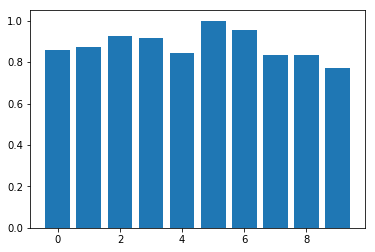

0.8817640692640693
0.8329545454545453


In [8]:
plt.bar(np.arange(len(res_df["best_acc"])), res_df["best_acc"])
plt.show()
print(np.mean(res_df["best_acc"]))
print(np.mean(res_df["final_acc"]))

In [9]:
print(np.mean(res_df["final_iter"]))

68.2


In [10]:
print(res_df["final_iter"])

0    55
1    63
2    78
3    79
4    55
5    99
6    58
7    64
8    76
9    55
Name: final_iter, dtype: int64


# Start inference

### Using best model checkpoint for inference

In [29]:
from collections import OrderedDict

In [30]:
metrics = []

random_states = np.arange(20, 30) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
        
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    # load data
    # separate new test set each run
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.15, random_state=r)
    if zero_one_normalize:
        intensity = IntensityRescale()
        ms_data_test = MSDataset(X_test, y_test, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    else:
        ms_data_test = MSDataset(X_test, y_test, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
    test_loader = DataLoader(
            ms_data_test, batch_size=1, num_workers=1, shuffle=False
)
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Bal Acc"])*100, np.std(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["ROC AUC"])*100, np.std(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Sensitivity"])*100, np.std(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Specificity"])*100, np.std(metrics_df["Specificity"])*100))

Outer fold 0
Bal. accuracy 78.409 %
ROC AUC Score 90.152 %
Sensitivity 75.000 %
Specificity 81.818 %
Outer fold 1
Bal. accuracy 70.635 %
ROC AUC Score 80.952 %
Sensitivity 55.556 %
Specificity 85.714 %
Outer fold 2
Bal. accuracy 69.615 %
ROC AUC Score 80.000 %
Sensitivity 69.231 %
Specificity 70.000 %
Outer fold 3
Bal. accuracy 76.587 %
ROC AUC Score 78.571 %
Sensitivity 64.286 %
Specificity 88.889 %
Outer fold 4
Bal. accuracy 69.444 %
ROC AUC Score 88.095 %
Sensitivity 88.889 %
Specificity 50.000 %
Outer fold 5
Bal. accuracy 85.317 %
ROC AUC Score 96.825 %
Sensitivity 77.778 %
Specificity 92.857 %
Outer fold 6
Bal. accuracy 87.500 %
ROC AUC Score 94.697 %
Sensitivity 75.000 %
Specificity 100.000 %
Outer fold 7
Bal. accuracy 95.833 %
ROC AUC Score 96.970 %
Sensitivity 91.667 %
Specificity 100.000 %
Outer fold 8
Bal. accuracy 80.159 %
ROC AUC Score 80.159 %
Sensitivity 71.429 %
Specificity 88.889 %
Outer fold 9
Bal. accuracy 64.773 %
ROC AUC Score 75.758 %
Sensitivity 75.000 %
Specifici